# **IMPORT LIBRARY**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt
from keras.models import Sequential
from scipy.interpolate import interp1d
from keras.layers import Dense, LSTM, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# **Collecting Data**


---



> Karena data diambil dari berbagai profince di indonesia, maka kita akan mengumpulkan data data yang bisa di gunakan di kota bandung, dan sekatiarnya, terkhusu di jawa bara, dengan tujuan, menghindari miss configurasi data, karena iklim tidak sesuai



In [4]:
dataset_rr = pd.read_csv('./climate_data.csv')
dataset_provice = pd.read_csv('./provice.csv')
dataset_station = pd.read_csv('./station.csv')


> **Data Checking** <br>Mengecek data yang sudah terkumpul, karena pada masing masing dataset terdapat id, dan kita akan menleakukan pengecekan apakah data tersebut merepresentasikan data pada file lain

In [5]:
dataset_rr.head()

date    Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg  \
0  01-01-2010  21.4  30.2  27.1    82.0   9.0  0.5   7.0   90.0     5.0   
1  02-01-2010  21.0  29.6  25.7    95.0  24.0  0.2   6.0   90.0     4.0   
2  03-01-2010  20.2  26.8  24.5    98.0  63.0  0.0   5.0   90.0     4.0   
3  04-01-2010  21.0  29.2  25.8    90.0   0.0  0.1   4.0  225.0     3.0   
4  05-01-2010  21.2  30.0  26.7    90.0   2.0  0.4   NaN    NaN     NaN   

  ddd_car  station_id  
0      E        96001  
1      E        96001  
2      E        96001  
3      SW       96001  
4     NaN       96001

In [6]:
dataset_provice.head()

province_id             province_name
0            1  Nanggroe Aceh Darussalam
1            2            Sumatera Utara
2            3            Sumatera Barat
3            4                      Riau
4            5                     Jambi

In [7]:
dataset_station.head()

station_id                                       station_name  \
0       96001                   Stasiun Meteorologi Maimun Saleh   
1       96003  Balai Besar Meteorologi Klimatologi  dan Geofi...   
2       96004  Balai Besar Meteorologi Klimatologi dan Geofis...   
3       96009                   Stasiun Meteorologi Malikussaleh   
4       96011           Stasiun Meteorologi Sultan Iskandar Muda   

       region_name  latitude  longitude  region_id  province_id  
0      Kota Sabang   5.87655   95.33785         20            1  
1      Kab. Badung  -8.73810  115.17860        272           17  
2    Kota Makassar  -5.14283  119.45227        412           26  
3  Kab. Aceh Utara   5.22869   96.94749          8            1  
4  Kab. Aceh Besar   5.52244   95.41700          6            1


> **Merging Data** <br>Setalah melakukan pengecekan dan dilakukan konfirmasi bahwa id memang betul betul merepresentasikan data pada file lain, selanjutnya data-data tersebut akan dilakukan merging sehingga data tidak akan terpisah-pisah lagi



In [8]:
merged_data= pd.merge(dataset_rr, dataset_station, on='station_id')
dataset_raw = pd.merge(merged_data, dataset_provice, on='province_id')

In [9]:
dataset_raw.head()


date    Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg  \
0  01-01-2010  21.4  30.2  27.1    82.0   9.0  0.5   7.0   90.0     5.0   
1  02-01-2010  21.0  29.6  25.7    95.0  24.0  0.2   6.0   90.0     4.0   
2  03-01-2010  20.2  26.8  24.5    98.0  63.0  0.0   5.0   90.0     4.0   
3  04-01-2010  21.0  29.2  25.8    90.0   0.0  0.1   4.0  225.0     3.0   
4  05-01-2010  21.2  30.0  26.7    90.0   2.0  0.4   NaN    NaN     NaN   

  ddd_car  station_id                      station_name  region_name  \
0      E        96001  Stasiun Meteorologi Maimun Saleh  Kota Sabang   
1      E        96001  Stasiun Meteorologi Maimun Saleh  Kota Sabang   
2      E        96001  Stasiun Meteorologi Maimun Saleh  Kota Sabang   
3      SW       96001  Stasiun Meteorologi Maimun Saleh  Kota Sabang   
4     NaN       96001  Stasiun Meteorologi Maimun Saleh  Kota Sabang   

   latitude  longitude  region_id  province_id             province_name  
0   5.87655   95.33785         20            1  Nanggroe Aceh Darussalam  
1   5.87655   95.33785         20            1  Nanggroe Aceh Darussalam  
2   5.87655   95.33785         20            1  Nanggroe Aceh Darussalam  
3   5.87655   95.33785         20            1  Nanggroe Aceh Darussalam  
4   5.87655   95.33785         20            1  Nanggroe Aceh Darussalam

In [10]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589265 entries, 0 to 589264
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           589265 non-null  object 
 1   Tn             565882 non-null  float64
 2   Tx             551529 non-null  float64
 3   Tavg           544160 non-null  float64
 4   RH_avg         541083 non-null  float64
 5   RR             463881 non-null  float64
 6   ss             545544 non-null  float64
 7   ff_x           579051 non-null  float64
 8   ddd_x          576137 non-null  float64
 9   ff_avg         579138 non-null  float64
 10  ddd_car        575526 non-null  object 
 11  station_id     589265 non-null  int64  
 12  station_name   589265 non-null  object 
 13  region_name    589265 non-null  object 
 14  latitude       589265 non-null  float64
 15  longitude      589265 non-null  float64
 16  region_id      589265 non-null  int64  
 17  province_id    589265 non-nul

In [11]:
# save to csv as a backup
dataset_raw.to_csv('./dataset_raw_rainfall.csv', index=False)

# **Data Pre-Processing**



> **Selecting Data** <br>Karena data yang dibutuhkan adala data yang berada di jawabarat terkhusus daerah bandung dan sekitarnya maka kita hanya akan mengambil data data tersbut untuk dilakukan proses pre-processing

> **Data Pre-Processing** <br>Data yang sudah dipilih kemudian dilakukan Pre-Processing agar memudahkan ketika melakukan proses *Feature Selection, and modeling* pre-processing yang dilakukan antara lain<br><ul><li>*Handle Missing Value*</li><li>*Encoding Column*</li><li>*Simulation Data Per Hour With Interpoliation*</li><li>Create target variable for 3 hours ahead rain prediction</li><li>Select features and target</li><li>Featuring Engineering</li></ul>



> **Selecting Data**



In [12]:
# check is Jawa Barat Exist in dataset
jawa_barat_data = dataset_raw.query('province_name == "Jawa Barat"')

In [13]:
jawa_barat_data.head()

date    Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg  \
276178  01-01-2010  19.0  27.6  21.8    82.0   7.0  3.8   3.0  270.0     1.0   
276179  02-01-2010  20.0  27.6  22.9    76.0   0.0  2.9   3.0  270.0     1.0   
276180  03-01-2010  20.0  25.8  21.8    86.0   0.0  3.4   4.0  270.0     1.0   
276181  04-01-2010  19.0  25.8  21.7    85.0   2.0  1.3   2.0  270.0     1.0   
276182  05-01-2010  19.0  26.8  21.5    87.0  12.0  1.8   2.0  270.0     0.0   

       ddd_car  station_id                station_name region_name  latitude  \
276178      W        96751  Stasiun Meteorologi Citeko  Kab. Bogor      -6.7   
276179      W        96751  Stasiun Meteorologi Citeko  Kab. Bogor      -6.7   
276180      W        96751  Stasiun Meteorologi Citeko  Kab. Bogor      -6.7   
276181      W        96751  Stasiun Meteorologi Citeko  Kab. Bogor      -6.7   
276182      W        96751  Stasiun Meteorologi Citeko  Kab. Bogor      -6.7   

        longitude  region_id  province_id province_name  
276178     106.85        158           12    Jawa Barat  
276179     106.85        158           12    Jawa Barat  
276180     106.85        158           12    Jawa Barat  
276181     106.85        158           12    Jawa Barat  
276182     106.85        158           12    Jawa Barat

In [14]:
# Check is dataset Contains Bandung Data
bandung_data = jawa_barat_data[jawa_barat_data.apply(lambda row: row.astype(str).str.contains('Bandung', case=False).any(), axis=1)]

In [15]:
bandung_data.head()

date    Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg  \
283973  01-01-2010  19.0  28.0  23.0    86.0   2.3  2.6   3.0  270.0     0.0   
283974  02-01-2010  20.0  29.0  22.9    86.0  21.0  4.1   4.0  180.0     1.0   
283975  03-01-2010  20.0  29.0  22.7    91.0  72.4  3.4   2.0  270.0     0.0   
283976  04-01-2010  20.0  28.5  22.7    87.0   1.7  3.5   4.0  270.0     0.0   
283977  05-01-2010  20.0  28.2  23.0    87.0   2.4  3.0   4.0  315.0     0.0   

       ddd_car  station_id               station_name   region_name  latitude  \
283973      W        96783  Stasiun Geofisika Bandung  Kota Bandung  -6.88356   
283974      W        96783  Stasiun Geofisika Bandung  Kota Bandung  -6.88356   
283975      W        96783  Stasiun Geofisika Bandung  Kota Bandung  -6.88356   
283976      W        96783  Stasiun Geofisika Bandung  Kota Bandung  -6.88356   
283977      W        96783  Stasiun Geofisika Bandung  Kota Bandung  -6.88356   

        longitude  region_id  province_id province_name  
283973  107.59733        177           12    Jawa Barat  
283974  107.59733        177           12    Jawa Barat  
283975  107.59733        177           12    Jawa Barat  
283976  107.59733        177           12    Jawa Barat  
283977  107.59733        177           12    Jawa Barat

In [16]:
# save as backup
bandung_data.to_csv('./bandung_dataset.csv')

In [17]:
dataset = pd.read_csv('./bandung_dataset.csv')

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     3910 non-null   int64  
 1   date           3910 non-null   object 
 2   Tn             3671 non-null   float64
 3   Tx             3704 non-null   float64
 4   Tavg           3877 non-null   float64
 5   RH_avg         3846 non-null   float64
 6   RR             3243 non-null   float64
 7   ss             3729 non-null   float64
 8   ff_x           3909 non-null   float64
 9   ddd_x          3908 non-null   float64
 10  ff_avg         3909 non-null   float64
 11  ddd_car        3892 non-null   object 
 12  station_id     3910 non-null   int64  
 13  station_name   3910 non-null   object 
 14  region_name    3910 non-null   object 
 15  latitude       3910 non-null   float64
 16  longitude      3910 non-null   float64
 17  region_id      3910 non-null   int64  
 18  province



> **Handle Missing Value**



In [19]:
# Cek Missing Value
dataset.isnull().sum()

Unnamed: 0         0
date               0
Tn               239
Tx               206
Tavg              33
RH_avg            64
RR               667
ss               181
ff_x               1
ddd_x              2
ff_avg             1
ddd_car           18
station_id         0
station_name       0
region_name        0
latitude           0
longitude          0
region_id          0
province_id        0
province_name      0
dtype: int64

In [20]:
dataset.ffill(inplace=True)

In [21]:
dataset.isnull().sum()

Unnamed: 0       0
date             0
Tn               0
Tx               0
Tavg             0
RH_avg           0
RR               0
ss               0
ff_x             0
ddd_x            0
ff_avg           0
ddd_car          0
station_id       0
station_name     0
region_name      0
latitude         0
longitude        0
region_id        0
province_id      0
province_name    0
dtype: int64



> **Interpolasi Data With CubicSpile Natural**



In [22]:
dataset = dataset.drop(columns=['Unnamed: 0', 'ddd_car', 'station_name', 'region_name', 'latitude', 'longitude', 'province_name'], axis=0)
dataset

date    Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg  \
0     01-01-2010  19.0  28.0  23.0    86.0   2.3  2.6   3.0  270.0     0.0   
1     02-01-2010  20.0  29.0  22.9    86.0  21.0  4.1   4.0  180.0     1.0   
2     03-01-2010  20.0  29.0  22.7    91.0  72.4  3.4   2.0  270.0     0.0   
3     04-01-2010  20.0  28.5  22.7    87.0   1.7  3.5   4.0  270.0     0.0   
4     05-01-2010  20.0  28.2  23.0    87.0   2.4  3.0   4.0  315.0     0.0   
...          ...   ...   ...   ...     ...   ...  ...   ...    ...     ...   
3905  27-12-2020  21.0  30.4  24.1    78.0   0.8  3.9   6.0  270.0     2.0   
3906  28-12-2020  21.0  30.0  24.7    72.0   0.8  8.3   7.0   60.0     3.0   
3907  29-12-2020  22.4  28.0  24.4    76.0   0.8  4.2   7.0  300.0     2.0   
3908  30-12-2020  21.8  27.4  22.7    76.0   0.9  2.6   5.0  260.0     3.0   
3909  31-12-2020  21.0  28.8  23.8    74.0   7.6  0.2   5.0  360.0     3.0   

      station_id  region_id  province_id  
0          96783        177           12  
1          96783        177           12  
2          96783        177           12  
3          96783        177           12  
4          96783        177           12  
...          ...        ...          ...  
3905       96783        177           12  
3906       96783        177           12  
3907       96783        177           12  
3908       96783        177           12  
3909       96783        177           12  

[3910 rows x 13 columns]

In [23]:
import pandas as pd
from scipy.interpolate import CubicSpline
import numpy as np

# Data cuaca harian Anda (contoh data Anda)
data = {
    'date': dataset['date'].tolist(),
    'Tn': dataset['Tn'].tolist(),
    'Tx': dataset['Tx'].tolist(),
    'Tavg': dataset['Tavg'].tolist(),
    'RH_avg': dataset['RH_avg'].tolist(),
    'RR': dataset['RR'].tolist(),
    'ss': dataset['ss'].tolist(),
    'ff_x': dataset['ff_x'].tolist(),
    'ddd_x': dataset['ddd_x'].tolist(),
    'ff_avg': dataset['ff_avg'].tolist(),
    'station_id': [96783] * len(dataset),
    'region_id': [177] * len(dataset),
    'province_id': [12] * len(dataset)
}

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Mengonversi kolom 'date' menjadi tipe datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Mengubah indeks DataFrame menjadi 'date'
df.set_index('date', inplace=True)

# Menghitung jumlah jam dari awal data
df['hour'] = df.index.hour

# Interpolasi kubik untuk setiap kolom numerik ke dalam data per jam
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        cubic_interp = CubicSpline(df.index, df[col], bc_type='natural')
        df[col] = cubic_interp(df.index)

# Mengubah data per jam menjadi data bulanan jika diinginkan
df = df.resample('H').mean().interpolate(method='cubic')

# Mengganti nilai negatif di kolom 'RR' dengan nol
df['RR'] = df['RR'].apply(lambda x: max(0, x))

# Untuk membulatkan angka
df = df.round(1)

# Menampilkan hasil
print(df)

                       Tn    Tx  Tavg  RH_avg   RR   ss  ff_x  ddd_x  ff_avg  \
date                                                                           
2010-01-01 00:00:00  19.0  28.0  23.0    86.0  2.3  2.6   3.0  270.0     0.0   
2010-01-01 01:00:00  19.1  28.1  23.0    85.6  0.0  2.8   3.2  257.6     0.1   
2010-01-01 02:00:00  19.2  28.1  23.0    85.3  0.0  2.9   3.5  246.2     0.3   
2010-01-01 03:00:00  19.2  28.2  23.0    85.0  0.0  3.1   3.7  235.8     0.4   
2010-01-01 04:00:00  19.3  28.3  23.0    84.7  0.0  3.2   3.8  226.2     0.5   
...                   ...   ...   ...     ...  ...  ...   ...    ...     ...   
2020-12-30 20:00:00  21.0  28.4  23.2    74.1  5.5  1.0   4.6  297.8     3.3   
2020-12-30 21:00:00  21.0  28.5  23.3    74.0  6.0  0.9   4.7  311.0     3.2   
2020-12-30 22:00:00  21.0  28.6  23.5    74.0  6.5  0.7   4.8  325.7     3.2   
2020-12-30 23:00:00  21.0  28.7  23.6    74.0  7.0  0.4   4.9  342.0     3.1   
2020-12-31 00:00:00  21.0  28.8  23.8   

/var/folders/fy/zb7jpw4146nc957ykgkprzch0000gn/T/ipykernel_76547/1443195016.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean().interpolate(method='cubic')


In [24]:
dataset_int = df.drop(columns=['hour'], axis=0)

In [25]:
dataset_int = df.rename(columns={'ddd_x': 'press_x'})

In [40]:
dataset_int

Tn    Tx  Tavg  RH_avg   RR   ss  ff_x  press_x  \
date                                                                     
2010-01-01 00:00:00  19.0  28.0  23.0    86.0  2.3  2.6   3.0    270.0   
2010-01-01 01:00:00  19.1  28.1  23.0    85.6  0.0  2.8   3.2    257.6   
2010-01-01 02:00:00  19.2  28.1  23.0    85.3  0.0  2.9   3.5    246.2   
2010-01-01 03:00:00  19.2  28.2  23.0    85.0  0.0  3.1   3.7    235.8   
2010-01-01 04:00:00  19.3  28.3  23.0    84.7  0.0  3.2   3.8    226.2   
...                   ...   ...   ...     ...  ...  ...   ...      ...   
2020-12-30 20:00:00  21.0  28.4  23.2    74.1  5.5  1.0   4.6    297.8   
2020-12-30 21:00:00  21.0  28.5  23.3    74.0  6.0  0.9   4.7    311.0   
2020-12-30 22:00:00  21.0  28.6  23.5    74.0  6.5  0.7   4.8    325.7   
2020-12-30 23:00:00  21.0  28.7  23.6    74.0  7.0  0.4   4.9    342.0   
2020-12-31 00:00:00  21.0  28.8  23.8    74.0  7.6  0.2   5.0    360.0   

                     ff_avg  station_id  region_id  province_id  hour  
date                                                                   
2010-01-01 00:00:00     0.0     96783.0      177.0         12.0   0.0  
2010-01-01 01:00:00     0.1     96783.0      177.0         12.0   0.0  
2010-01-01 02:00:00     0.3     96783.0      177.0         12.0   0.0  
2010-01-01 03:00:00     0.4     96783.0      177.0         12.0   0.0  
2010-01-01 04:00:00     0.5     96783.0      177.0         12.0   0.0  
...                     ...         ...        ...          ...   ...  
2020-12-30 20:00:00     3.3     96783.0      177.0         12.0   0.0  
2020-12-30 21:00:00     3.2     96783.0      177.0         12.0   0.0  
2020-12-30 22:00:00     3.2     96783.0      177.0         12.0   0.0  
2020-12-30 23:00:00     3.1     96783.0      177.0         12.0   0.0  
2020-12-31 00:00:00     3.0     96783.0      177.0         12.0   0.0  

[96409 rows x 13 columns]

In [26]:
dataset_int.to_csv('./bandung_interpolasi.csv')



> **Data Visualization After Interpolating**



In [27]:
data = pd.read_csv('./bandung_interpolasi.csv')

In [28]:
data['date'] = pd.to_datetime(data['date'])

# Resample the data to daily and hourly means
data_daily = data.resample('D', on='date').mean()
data_hourly = data.resample('H', on='date').mean()

/var/folders/fy/zb7jpw4146nc957ykgkprzch0000gn/T/ipykernel_76547/1081757388.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hourly = data.resample('H', on='date').mean()


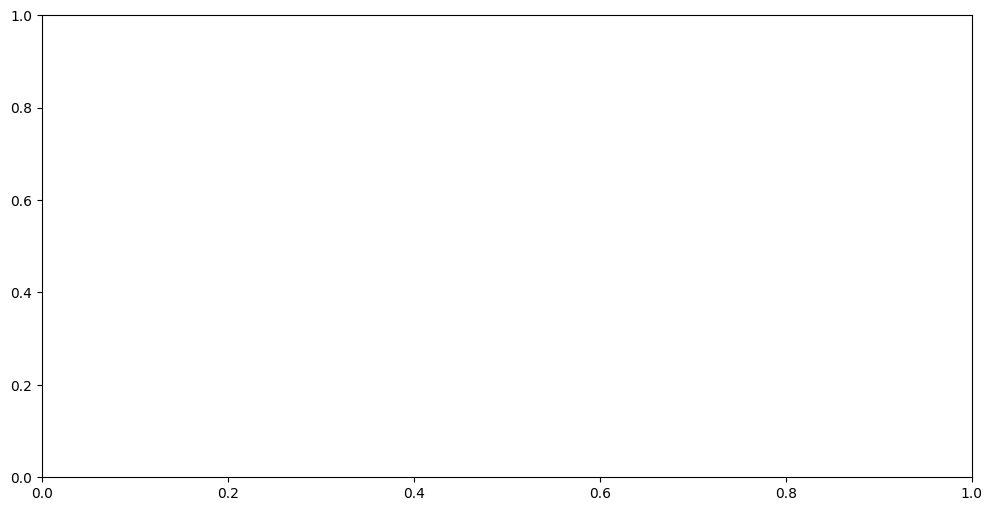

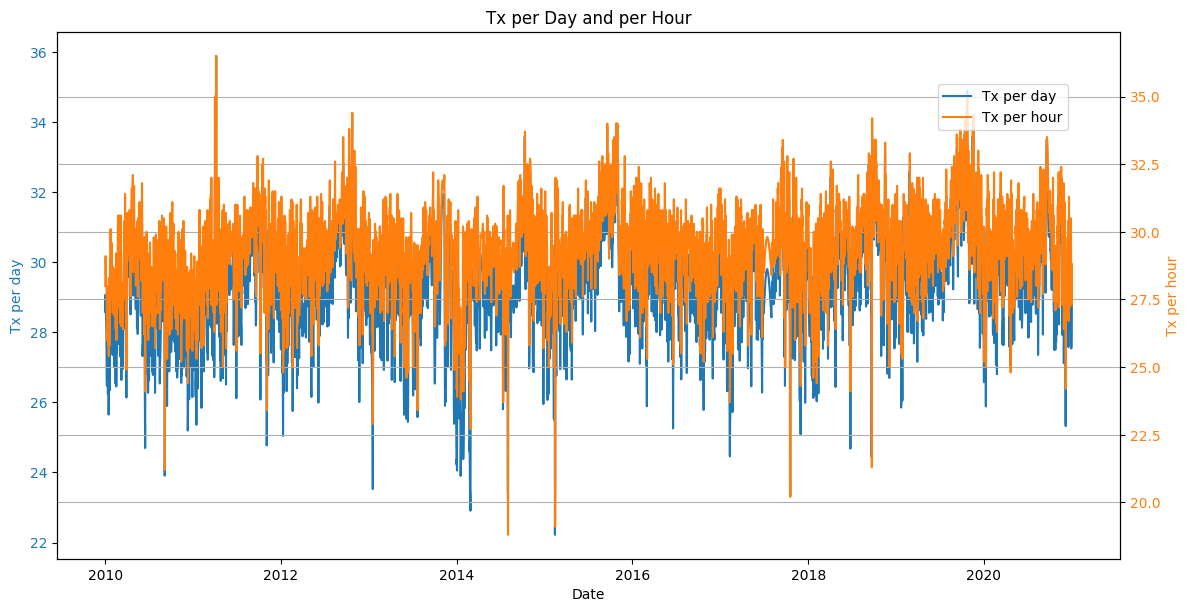

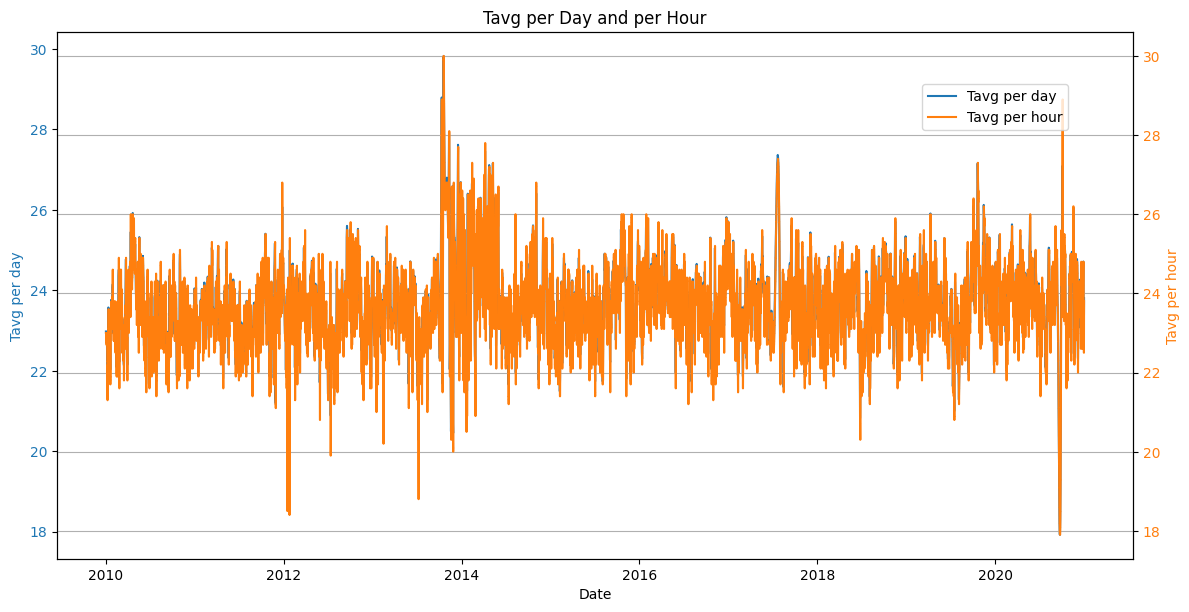

In [29]:
# Plot the first graph (Tn per day and per hour) with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the second graph (Tx per day and per hour) with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Tx per day', color='tab:blue')
ax1.plot(data_daily.index, data_daily['Tx'], label='Tx per day', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Tx per hour', color='tab:orange')
ax2.plot(data_hourly.index, data_hourly['Tx'], label='Tx per hour', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Tx per Day and per Hour')
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.show()

# Plot the third graph (Tavg per day and per hour) with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Tavg per day', color='tab:blue')
ax1.plot(data_daily.index, data_daily['Tavg'], label='Tavg per day', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Tavg per hour', color='tab:orange')
ax2.plot(data_hourly.index, data_hourly['Tavg'], label='Tavg per hour', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Tavg per Day and per Hour')
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.show()




> **Visualisasi dengan bentuk data yang lebih sederhana agar, bisa memastikan bahwa interpolasi, memang merepresentasikan data yang sebenarnya**



/var/folders/fy/zb7jpw4146nc957ykgkprzch0000gn/T/ipykernel_76547/4073890688.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hourly_filtered = data_filtered.resample('H', on='date').mean()


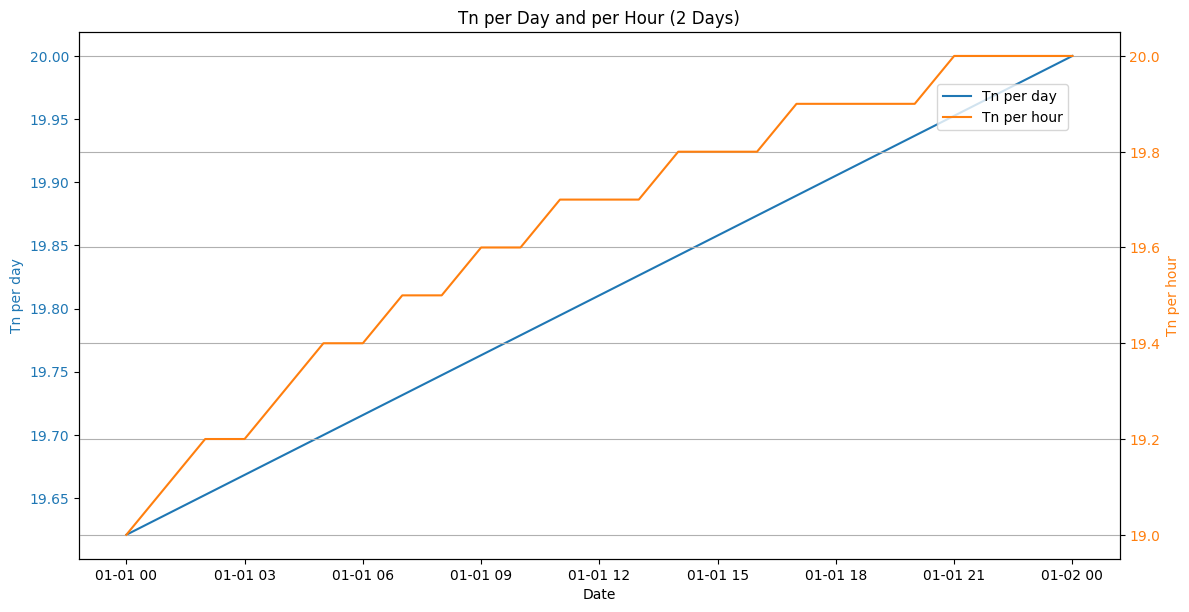

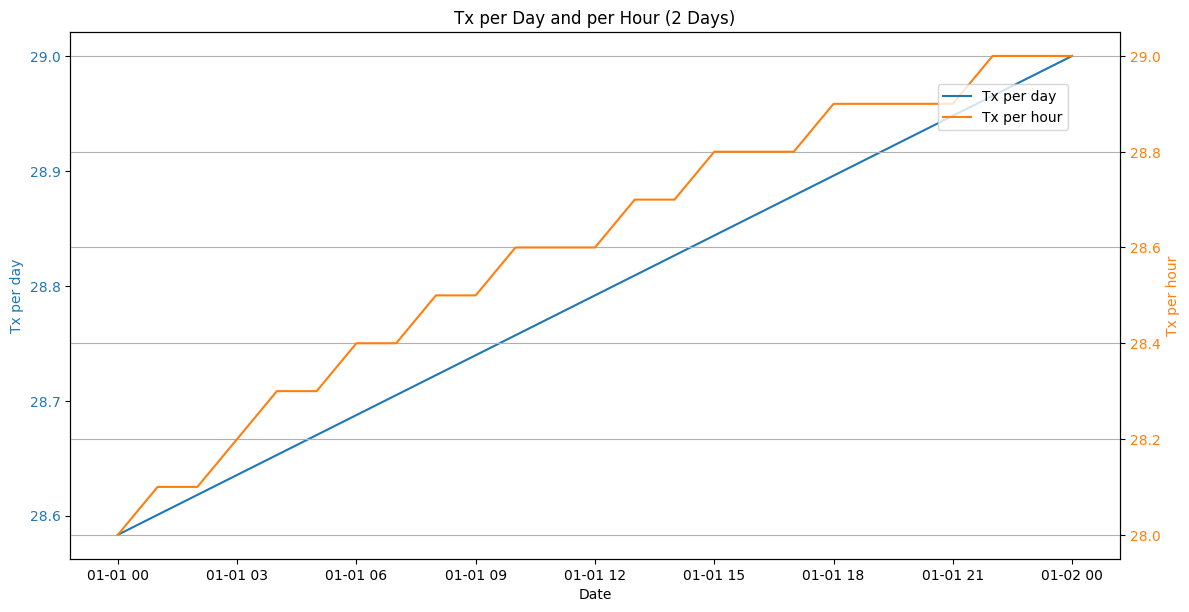

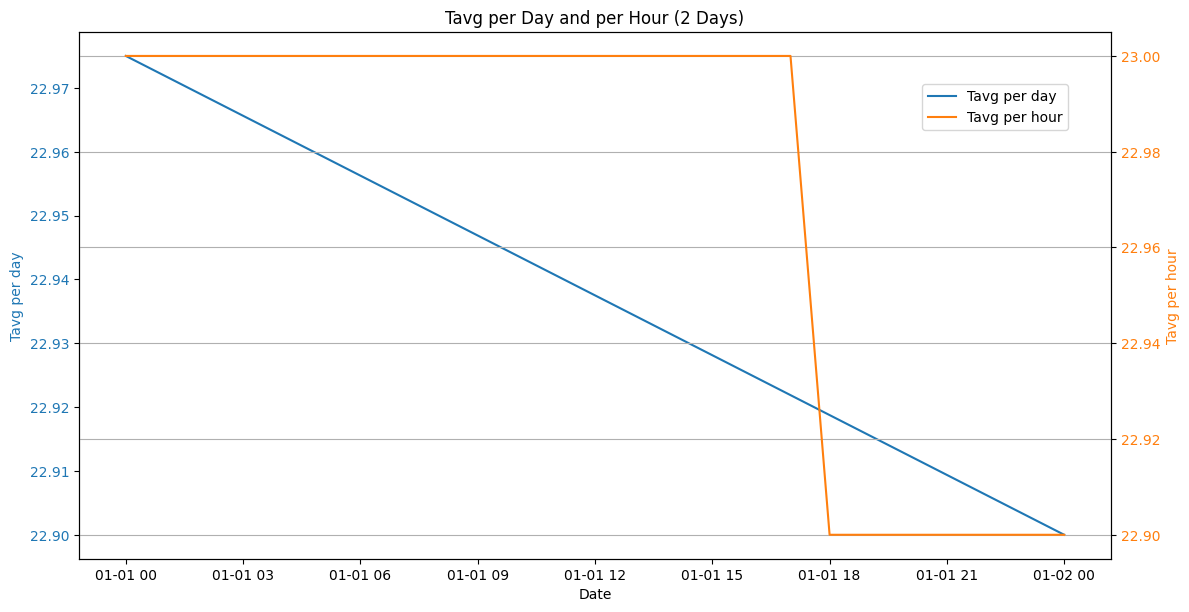

In [30]:
# Filter data for only two days
start_date = '2010-01-01'
end_date = '2010-01-02'

# Filter the data
data_filtered = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Resample the filtered data to daily and hourly means
data_daily_filtered = data_filtered.resample('D', on='date').mean()
data_hourly_filtered = data_filtered.resample('H', on='date').mean()

# Plot the first graph (Tn per day and per hour) with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Tn per day', color='tab:blue')
ax1.plot(data_daily_filtered.index, data_daily_filtered['Tn'], label='Tn per day', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Tn per hour', color='tab:orange')
ax2.plot(data_hourly_filtered.index, data_hourly_filtered['Tn'], label='Tn per hour', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Tn per Day and per Hour (2 Days)')
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.show()

# Plot the second graph (Tx per day and per hour) with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Tx per day', color='tab:blue')
ax1.plot(data_daily_filtered.index, data_daily_filtered['Tx'], label='Tx per day', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Tx per hour', color='tab:orange')
ax2.plot(data_hourly_filtered.index, data_hourly_filtered['Tx'], label='Tx per hour', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Tx per Day and per Hour (2 Days)')
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.show()

# Plot the third graph (Tavg per day and per hour) with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Tavg per day', color='tab:blue')
ax1.plot(data_daily_filtered.index, data_daily_filtered['Tavg'], label='Tavg per day', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Tavg per hour', color='tab:orange')
ax2.plot(data_hourly_filtered.index, data_hourly_filtered['Tavg'], label='Tavg per hour', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Tavg per Day and per Hour (2 Days)')
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.grid(True)
plt.show()




> **Label Encoder: Merubah data Rainfall dari curah hujan menjadi 0 dan 1, label RR > 1 maka result nya 1 selain itu 0, artinya tidak hujan**



In [31]:
dataset_clean = pd.read_csv('./bandung_interpolasi.csv')

In [32]:
dataset_clean['rain'] = dataset_clean['RR'].apply(lambda x: 1 if x > 1 else 0)

In [33]:
dataset_clean[['date', 'rain', 'RR']].head()

date  rain   RR
0  2010-01-01 00:00:00     1  2.3
1  2010-01-01 01:00:00     0  0.0
2  2010-01-01 02:00:00     0  0.0
3  2010-01-01 03:00:00     0  0.0
4  2010-01-01 04:00:00     0  0.0

In [34]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96409 entries, 0 to 96408
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         96409 non-null  object 
 1   Tn           96409 non-null  float64
 2   Tx           96409 non-null  float64
 3   Tavg         96409 non-null  float64
 4   RH_avg       96409 non-null  float64
 5   RR           96409 non-null  float64
 6   ss           96409 non-null  float64
 7   ff_x         96409 non-null  float64
 8   press_x      96409 non-null  float64
 9   ff_avg       96409 non-null  float64
 10  station_id   96409 non-null  float64
 11  region_id    96409 non-null  float64
 12  province_id  96409 non-null  float64
 13  hour         96409 non-null  float64
 14  rain         96409 non-null  int64  
dtypes: float64(13), int64(1), object(1)
memory usage: 11.0+ MB


In [35]:
# dataset_clean['rain_next_3_hours'] = dataset_clean['rain'].shift(-3).apply(lambda x: 1 if x > 0 else 0)



> **Featuring Engineering**



In [36]:
features = ['Tavg', 'RH_avg', 'ff_avg']
target = 'rain'
X = dataset_clean[features]
y = dataset_clean[target]

# Add features for the last few hours
# for i in range(1, 4):
#     for feature in features:
#         dataset_clean[f'{feature}_lag_{i}'] = dataset_clean[feature].shift(i)



> **Create target variable for 3 hours ahead rain prediction**



In [37]:
def create_sequences(data, labels, time_steps=3):
    sequences = []
    label_sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        label_sequences.append(labels[i + time_steps])
    return np.array(sequences), np.array(label_sequences)

In [38]:
time_steps = 3  # Menggunakan 3 jam data sebelumnya untuk memprediksi 3 jam ke depan
X, y = create_sequences(X, y, time_steps)

/var/folders/fy/zb7jpw4146nc957ykgkprzch0000gn/T/ipykernel_76547/2029942555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = dataset_clean['rain'].shift(-3)


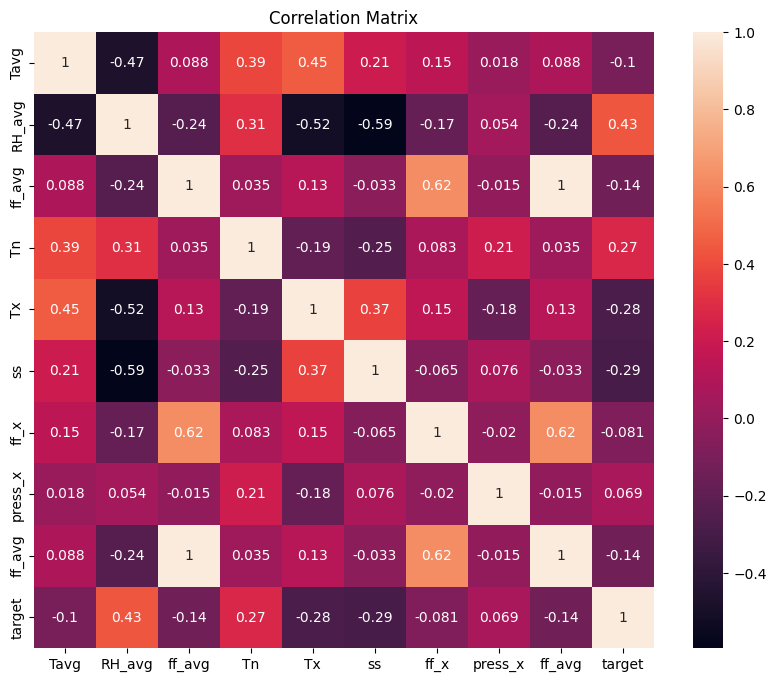

In [42]:
data = dataset_clean[['Tavg', 'RH_avg', 'ff_avg', 'Tn', 'Tx', 'ss', 'ff_x', 'press_x', 'ff_avg']]
data['target'] = dataset_clean['rain'].shift(-3)
matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Drop rows with NaN values created by the shift operation
# data = data.dropna()

In [ ]:
# features += [f'{feature}_lag_{i}' for i in range(1, 4) for feature in features]
# X = dataset_clean[features]
# y = dataset_clean[target]

# **Modeling**



> **Splitting Data** <br> Membagi dataset menjadi 2 bagian, Test data dan Train data, dengan size 80:20

> **Modeling** <br> melakukan pemodelan degan menggunakan model yang menggunakanneural network yang diimplementasikan dengan TensorFlow dan Keras. Model terdiri dari beberapa lapisan Dense dengan fungsi aktivasi relu untuk lapisan tersembunyi dan sigmoid untuk lapisan output.








> **Splitting Dataset**



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [ ]:
X_test

array([[[21.8, 81.9,  1. ],
        [21.7, 82. ,  1. ],
        [21.7, 82.1,  1. ]],

       [[26.6, 51.6,  1.9],
        [26.7, 51. ,  1.9],
        [26.8, 50.5,  1.9]],

       [[24.2, 62.5,  2. ],
        [24.2, 62.4,  2. ],
        [24.2, 62.4,  2. ]],

       ...,

       [[24.4, 75.5,  1.5],
        [24.4, 75.3,  1.4],
        [24.5, 75.2,  1.4]],

       [[23.5, 70. ,  2. ],
        [23.5, 70. ,  1.9],
        [23.5, 70. ,  1.9]],

       [[24. , 75.3,  1.2],
        [24. , 75.4,  1.3],
        [24. , 75.4,  1.3]]])



> **Building Model/ Modeling**



In [ ]:
import multiprocessing

# Set the start method to 'spawn'
multiprocessing.set_start_method('spawn', force=True)

# Define the LSTM network architecture
def create_lstm_model(units):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(time_steps, X_train.shape[2])))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

# Define the grid search parameters
param = {
    'batch_size': [50, 25, 32],
    'epochs': [20, 80, 100, 200],
    'model__units': [10, 11, 12, 15],  # Changed 'unit' to 'units'
}

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_lstm_model)

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param, cv=3)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best accuracy of: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.4637 - loss: 0.2682
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.5949 - loss: 0.2330
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7166 - loss: 0.2077
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7209 - loss: 0.1957
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.7149 - loss: 0.1923
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7256 - loss: 0.1889
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7129 - loss: 0.1907
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.7217 - loss: 0.1871
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.1887  
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7275 - loss: 0.1869
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7271 - loss: 0.1849
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.6095 - loss: 0.2270
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.7221 - loss: 0.1939
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.7260 - loss: 0.1863
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.7265 - loss: 0.1864
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.7213 - loss: 0.1880
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.7277 - loss: 0.1846
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7287 - loss: 0.1856
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7274 - loss: 0.1848
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.7334 - loss: 0.1824
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7278 - loss: 0.1846
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.7288 - loss: 0.1852
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.5654 - loss: 0.2479
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.5769 - loss: 0.2378
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.7054 - loss: 0.2096
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.7286 - loss: 0.1907
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.7162 - loss: 0.1887
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.7247 - loss: 0.1862
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.7212 - loss: 0.1868
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7272 - loss: 0.1851
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7291 - loss: 0.1848
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.7359 - loss: 0.1809
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7189 - loss: 0.1883
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.5841 - loss: 0.2412
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.7180 - loss: 0.1995
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.7229 - loss: 0.1900
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7150 - loss: 0.1928
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.7234 - loss: 0.1874
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.7268 - loss: 0.1871
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7209 - loss: 0.1871
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.7269 - loss: 0.1863
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7345 - loss: 0.1838
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.7253 - loss: 0.1861
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.7289 - loss: 0.1844
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.5563 - loss: 0.2460
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7111 - loss: 0.2115
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.7298 - loss: 0.1883
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.7265 - loss: 0.1855
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.7345 - loss: 0.1834
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.7309 - loss: 0.1843
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.7200 - loss: 0.1890
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.7302 - loss: 0.1851
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.7309 - loss: 0.1837
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7245 - loss: 0.1874  
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7303 - loss: 0.1839
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.6694 - loss: 0.2304
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7275 - loss: 0.1912
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.7332 - loss: 0.1839
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7311 - loss: 0.1833
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.7321 - loss: 0.1819
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.7244 - loss: 0.1852
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.7347 - loss: 0.1812
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7314 - loss: 0.1822
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.7344 - loss: 0.1816
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7318 - loss: 0.1813
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7387 - loss: 0.1787
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.6773 - loss: 0.2185
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.7167 - loss: 0.1930
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.7192 - loss: 0.1914
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7236 - loss: 0.1890
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.7264 - loss: 0.1873
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7253 - loss: 0.1865
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.7265 - loss: 0.1865
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.7200 - loss: 0.1883
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7317 - loss: 0.1841
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.7265 - loss: 0.1872
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.7345 - loss: 0.1809
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - accuracy: 0.5801 - loss: 0.2406
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6967 - loss: 0.2104
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7204 - loss: 0.1905
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7303 - loss: 0.1844
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.7354 - loss: 0.1831
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.7309 - loss: 0.1839
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.7361 - loss: 0.1800
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.7359 - loss: 0.1810
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.7409 - loss: 0.1775
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7468 - loss: 0.1741
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.7457 - loss: 0.1755
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.6230 - loss: 0.2296
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7176 - loss: 0.1928
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.7253 - loss: 0.1878
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7135 - loss: 0.1916
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.7224 - loss: 0.1858
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.7236 - loss: 0.1858
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.7243 - loss: 0.1839
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.7329 - loss: 0.1815
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7319 - loss: 0.1828
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.7264 - loss: 0.1832
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.7373 - loss: 0.1784
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.5862 - loss: 0.2396
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.7199 - loss: 0.1934
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7169 - loss: 0.1912
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.7287 - loss: 0.1864
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7287 - loss: 0.1847
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7295 - loss: 0.1838
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.7282 - loss: 0.1859
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7337 - loss: 0.1824
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.7310 - loss: 0.1822
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.7261 - loss: 0.1852
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7309 - loss: 0.1827
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.5847 - loss: 0.2386
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7071 - loss: 0.1984
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.7207 - loss: 0.1884
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7248 - loss: 0.1865
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.7330 - loss: 0.1813
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.7297 - loss: 0.1836
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7385 - loss: 0.1793
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7254 - loss: 0.1847
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.7454 - loss: 0.1756
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.7393 - loss: 0.1781
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7408 - loss: 0.1782
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.6554 - loss: 0.2248
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.7192 - loss: 0.1901
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.7343 - loss: 0.1833
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.7305 - loss: 0.1837
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.7296 - loss: 0.1840
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.7305 - loss: 0.1849
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7259 - loss: 0.1849
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7286 - loss: 0.1802
Epoch 9/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.7310 - loss: 0.1808
Epoch 10/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.7386 - loss: 0.1791
Epoch 11/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.7354 - loss: 0.1804
Epoch 12/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.5676 - loss: 0.2441
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6527 - loss: 0.2233
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.7162 - loss: 0.1976
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7250 - loss: 0.1872
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.7245 - loss: 0.1857
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.7423 - loss: 0.1808
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.7328 - loss: 0.1844
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7298 - loss: 0.1851
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7289 - loss: 0.1851
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.7289 - loss: 0.1848
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7316 - loss: 0.1829
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.6420 - loss: 0.2336
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.7358 - loss: 0.1954
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7296 - loss: 0.1849
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.7346 - loss: 0.1812
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7416 - loss: 0.1802
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7325 - loss: 0.1807
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.7379 - loss: 0.1813
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.7399 - loss: 0.1781
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.7373 - loss: 0.1794
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.7432 - loss: 0.1776
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.7334 - loss: 0.1803
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.6511 - loss: 0.2155
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.7115 - loss: 0.1954
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.7181 - loss: 0.1911
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.7230 - loss: 0.1883
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.7291 - loss: 0.1871
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.7229 - loss: 0.1876
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.7290 - loss: 0.1842
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.7279 - loss: 0.1850
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7282 - loss: 0.1836
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7326 - loss: 0.1830
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7301 - loss: 0.1842
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.6039 - loss: 0.2326
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.7145 - loss: 0.1946
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.7199 - loss: 0.1885
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.7104 - loss: 0.1914
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.7247 - loss: 0.1861
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.7257 - loss: 0.1886
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.7270 - loss: 0.1852
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.7306 - loss: 0.1833
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.7250 - loss: 0.1851
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.7376 - loss: 0.1822
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.7373 - loss: 0.1809
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.6723 - loss: 0.2229
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.7264 - loss: 0.1864
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.7306 - loss: 0.1851
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.7359 - loss: 0.1810
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.7269 - loss: 0.1844
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.7310 - loss: 0.1832
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.7275 - loss: 0.1845
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7371 - loss: 0.1814
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.7285 - loss: 0.1862
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7340 - loss: 0.1817
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7417 - loss: 0.1780
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.5872 - loss: 0.2358
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.7132 - loss: 0.1946
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.7342 - loss: 0.1816
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.7335 - loss: 0.1816
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7360 - loss: 0.1812
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.7362 - loss: 0.1806
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.7306 - loss: 0.1827
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.7269 - loss: 0.1838
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7243 - loss: 0.1856
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.7356 - loss: 0.1802
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7318 - loss: 0.1811
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.5919 - loss: 0.2243
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.7193 - loss: 0.1919
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.7278 - loss: 0.1874
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.7260 - loss: 0.1879
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.7272 - loss: 0.1871
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.7251 - loss: 0.1895
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.7297 - loss: 0.1849
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.7307 - loss: 0.1858
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7276 - loss: 0.1852
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.7271 - loss: 0.1884
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7298 - loss: 0.1837
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.5930 - loss: 0.2364
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7280 - loss: 0.1933
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.7299 - loss: 0.1854
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.7264 - loss: 0.1855
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.7380 - loss: 0.1806
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.7349 - loss: 0.1810
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.7338 - loss: 0.1811
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.7436 - loss: 0.1765
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7336 - loss: 0.1822
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7350 - loss: 0.1806
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7340 - loss: 0.1819
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 6

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 873us/step - accuracy: 0.6612 - loss: 0.2307
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7124 - loss: 0.1930
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.7196 - loss: 0.1885
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.7263 - loss: 0.1864
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.7272 - loss: 0.1847
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7189 - loss: 0.1866
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7240 - loss: 0.1888
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7290 - loss: 0.1859
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7267 - loss: 0.1848
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.7294 - loss: 0.1832
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.7266 - loss: 0.1850
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 665

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.6198 - loss: 0.2320
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7207 - loss: 0.1899
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.7247 - loss: 0.1879
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.7235 - loss: 0.1872
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7303 - loss: 0.1858
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.7296 - loss: 0.1843
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7342 - loss: 0.1822
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7317 - loss: 0.1835
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7368 - loss: 0.1818
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7329 - loss: 0.1824
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.7415 - loss: 0.1804
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 6

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.6377 - loss: 0.2269
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7205 - loss: 0.1870
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.7304 - loss: 0.1830
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7310 - loss: 0.1842
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.7350 - loss: 0.1824
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7299 - loss: 0.1846
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7367 - loss: 0.1813
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.7365 - loss: 0.1796
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7315 - loss: 0.1833
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7377 - loss: 0.1798
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.7302 - loss: 0.1825
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 6

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.5003 - loss: 0.2547
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.6154 - loss: 0.2335
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.7155 - loss: 0.1964
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7157 - loss: 0.1891
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.7185 - loss: 0.1880
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.7231 - loss: 0.1854
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7215 - loss: 0.1864
Epoch 8/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7264 - loss: 0.1848
Epoch 9/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.7285 - loss: 0.1833
Epoch 10/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7290 - loss: 0.1834
Epoch 11/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.7347 - loss: 0.1816
Epoch 12/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.5931 - loss: 0.2289
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.7178 - loss: 0.1913
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.7256 - loss: 0.1880
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.7233 - loss: 0.1893
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.7291 - loss: 0.1866
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.7187 - loss: 0.1895
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.7236 - loss: 0.1875
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7311 - loss: 0.1843
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.7196 - loss: 0.1928
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7241 - loss: 0.1869
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7287 - loss: 0.1838
Epoch 12/100
258/258 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.6070 - loss: 0.2346
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7240 - loss: 0.1899
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7224 - loss: 0.1888
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.7301 - loss: 0.1850
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.7180 - loss: 0.1893
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.7387 - loss: 0.1811
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.7299 - loss: 0.1837
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.7255 - loss: 0.1848
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.7337 - loss: 0.1840
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.7387 - loss: 0.1801
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7304 - loss: 0.1821
Epoch 12/100
258/258 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.5662 - loss: 0.2511
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.7133 - loss: 0.1998
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.7280 - loss: 0.1881
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.7184 - loss: 0.1902
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.7207 - loss: 0.1875
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.7199 - loss: 0.1898
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.7293 - loss: 0.1861
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.7192 - loss: 0.1888
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.7172 - loss: 0.1904
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.7233 - loss: 0.1864
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7231 - loss: 0.1866
Epoch 12/100
258/258 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.4940 - loss: 0.2511
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.5864 - loss: 0.2282
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.7039 - loss: 0.2061
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7162 - loss: 0.1933
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7087 - loss: 0.1928
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.7207 - loss: 0.1889
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.7192 - loss: 0.1891
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.7201 - loss: 0.1875
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.7232 - loss: 0.1864
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7248 - loss: 0.1859
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7287 - loss: 0.1849
Epoch 12/100
258/258 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.6324 - loss: 0.2294
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.7275 - loss: 0.1882
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7301 - loss: 0.1854
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.7312 - loss: 0.1847
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.7355 - loss: 0.1822
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.7308 - loss: 0.1832
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.7298 - loss: 0.1840
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7380 - loss: 0.1818
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.7356 - loss: 0.1810
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7329 - loss: 0.1824
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.7350 - loss: 0.1823
Epoch 12/100
258/258 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.5932 - loss: 0.2353
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.7164 - loss: 0.1970
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.7232 - loss: 0.1878
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.7347 - loss: 0.1814
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.7215 - loss: 0.1868
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.7334 - loss: 0.1818
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.7246 - loss: 0.1842
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7261 - loss: 0.1860
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.7266 - loss: 0.1839
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.7366 - loss: 0.1783
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.7377 - loss: 0.1802
Epoch 12/100
258/258 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.5885 - loss: 0.2339
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7142 - loss: 0.1938
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7115 - loss: 0.1940
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.7239 - loss: 0.1892
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.7264 - loss: 0.1861
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.7257 - loss: 0.1861
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7263 - loss: 0.1836
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.7220 - loss: 0.1856
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.7267 - loss: 0.1843
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7330 - loss: 0.1807
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7358 - loss: 0.1799
Epoch 12/100
258/258 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.5590 - loss: 0.2468
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.7259 - loss: 0.1981
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.7243 - loss: 0.1861
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.7204 - loss: 0.1879
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.7240 - loss: 0.1884
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7293 - loss: 0.1847
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.7317 - loss: 0.1834
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.7365 - loss: 0.1803
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7304 - loss: 0.1845
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.7394 - loss: 0.1798
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.7364 - loss: 0.1815
Epoch 12/100
258/258 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.5327 - loss: 0.2591
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.7194 - loss: 0.2042
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.7174 - loss: 0.1905
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7249 - loss: 0.1854
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.7349 - loss: 0.1819
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7454 - loss: 0.1768
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.7303 - loss: 0.1828
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7329 - loss: 0.1819
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.7371 - loss: 0.1805
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.7288 - loss: 0.1835
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7300 - loss: 0.1816
Epoch 12/100
258/258 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.5633 - loss: 0.2512
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.7282 - loss: 0.1912
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7179 - loss: 0.1910
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7271 - loss: 0.1866
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7350 - loss: 0.1828
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.7278 - loss: 0.1827
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.7292 - loss: 0.1834
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.7207 - loss: 0.1873
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.7265 - loss: 0.1841
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.7330 - loss: 0.1837
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7259 - loss: 0.1837
Epoch 12/100
258/258 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.5799 - loss: 0.2468
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7167 - loss: 0.1894
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.7282 - loss: 0.1863
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.7260 - loss: 0.1854
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7305 - loss: 0.1849
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.7269 - loss: 0.1860
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.7288 - loss: 0.1836
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.7255 - loss: 0.1849
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.7359 - loss: 0.1796
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7320 - loss: 0.1834
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.7273 - loss: 0.1848
Epoch 12/100
258/258 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.6038 - loss: 0.2346
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7166 - loss: 0.1915
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.7196 - loss: 0.1884
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.7303 - loss: 0.1832
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.7286 - loss: 0.1851
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7304 - loss: 0.1836
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.7327 - loss: 0.1839
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7312 - loss: 0.1817
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7321 - loss: 0.1806
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7243 - loss: 0.1849
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.7326 - loss: 0.1823
Epoch 12/100
258/258 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.4792 - loss: 0.2532
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.6221 - loss: 0.2280
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.7153 - loss: 0.1947
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7200 - loss: 0.1879
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.7232 - loss: 0.1881
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.7158 - loss: 0.1901
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.7296 - loss: 0.1845
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.7264 - loss: 0.1867
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.7194 - loss: 0.1885
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7186 - loss: 0.1884
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7288 - loss: 0.1865
Epoch 12/200
258/258 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.6310 - loss: 0.2271
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.7275 - loss: 0.1889
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.7214 - loss: 0.1894
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.7333 - loss: 0.1820
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.7286 - loss: 0.1855
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.7341 - loss: 0.1830
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.7314 - loss: 0.1841
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.7284 - loss: 0.1864
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.7302 - loss: 0.1865
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.7358 - loss: 0.1819
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.7349 - loss: 0.1812
Epoch 12/200
258/258 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5155 - loss: 0.2495
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.6569 - loss: 0.2194
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.7056 - loss: 0.1993
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7190 - loss: 0.1903
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.7151 - loss: 0.1898
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.7256 - loss: 0.1864
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.7207 - loss: 0.1876
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.7236 - loss: 0.1845
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.7239 - loss: 0.1871
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.7263 - loss: 0.1846
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7306 - loss: 0.1813
Epoch 12/200
258/258 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.5717 - loss: 0.2406
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.7162 - loss: 0.1950
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.7165 - loss: 0.1911
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.7267 - loss: 0.1870
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.7231 - loss: 0.1892
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.7175 - loss: 0.1914
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.7239 - loss: 0.1893
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.7168 - loss: 0.1898
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.7245 - loss: 0.1872
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7232 - loss: 0.1868
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.7247 - loss: 0.1883
Epoch 12/200
258/258 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5392 - loss: 0.2441
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6725 - loss: 0.2170
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7229 - loss: 0.1985
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.7319 - loss: 0.1882
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.7340 - loss: 0.1836
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7335 - loss: 0.1839
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7407 - loss: 0.1797
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7373 - loss: 0.1804
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.7340 - loss: 0.1819
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7366 - loss: 0.1805
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7341 - loss: 0.1809
Epoch 12/200
258/258 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5003 - loss: 0.2538
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.5807 - loss: 0.2402
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7055 - loss: 0.2108
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7201 - loss: 0.1916
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7198 - loss: 0.1881
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7252 - loss: 0.1875
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.7234 - loss: 0.1872
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.7269 - loss: 0.1835
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.7284 - loss: 0.1840
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7276 - loss: 0.1849
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.7352 - loss: 0.1814
Epoch 12/200
258/258 ━━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.6630 - loss: 0.2366
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7176 - loss: 0.2016
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7254 - loss: 0.1880
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7241 - loss: 0.1862
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.7213 - loss: 0.1881
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7312 - loss: 0.1835
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7301 - loss: 0.1828
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.7277 - loss: 0.1853
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7315 - loss: 0.1825
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.7363 - loss: 0.1844
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7307 - loss: 0.1830
Epoch 12/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.4857 - loss: 0.2560
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.6679 - loss: 0.2248
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.7143 - loss: 0.2037
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7308 - loss: 0.1873
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.7311 - loss: 0.1849
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7414 - loss: 0.1809
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.7421 - loss: 0.1807
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.7306 - loss: 0.1841
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7308 - loss: 0.1834
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7301 - loss: 0.1829
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.7395 - loss: 0.1818
Epoch 12/200
258/258 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.5299 - loss: 0.2534
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7245 - loss: 0.1966
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7226 - loss: 0.1893
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7411 - loss: 0.1812
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.7277 - loss: 0.1861
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7316 - loss: 0.1829
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7190 - loss: 0.1866
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.7294 - loss: 0.1854
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.7331 - loss: 0.1831
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7317 - loss: 0.1823
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7286 - loss: 0.1824
Epoch 12/200
258/258 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.5841 - loss: 0.2374
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.7080 - loss: 0.1972
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.7113 - loss: 0.1933
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.7211 - loss: 0.1890
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.7261 - loss: 0.1872
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.7235 - loss: 0.1872
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.7213 - loss: 0.1877
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7254 - loss: 0.1860
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.7270 - loss: 0.1856
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.7321 - loss: 0.1808
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.7238 - loss: 0.1850
Epoch 12/200
258/258 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.6124 - loss: 0.2302
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.7194 - loss: 0.1898
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.7276 - loss: 0.1842
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.7266 - loss: 0.1858
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7264 - loss: 0.1874
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7346 - loss: 0.1831
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7347 - loss: 0.1819
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7424 - loss: 0.1806
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7426 - loss: 0.1786
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7319 - loss: 0.1820
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.7385 - loss: 0.1793
Epoch 12/200
258/258 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.6025 - loss: 0.2298
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7199 - loss: 0.1885
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7271 - loss: 0.1863
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7147 - loss: 0.1915
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7255 - loss: 0.1854
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7153 - loss: 0.1890
Epoch 7/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7284 - loss: 0.1848
Epoch 8/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7360 - loss: 0.1826
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.7283 - loss: 0.1830
Epoch 10/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7367 - loss: 0.1787
Epoch 11/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.7286 - loss: 0.1828
Epoch 12/200
258/258 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 908us/step - accuracy: 0.6360 - loss: 0.2187
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7062 - loss: 0.1944
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7246 - loss: 0.1887
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7232 - loss: 0.1875
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.7309 - loss: 0.1861
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.7305 - loss: 0.1837
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7316 - loss: 0.1834
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.7289 - loss: 0.1851
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.7383 - loss: 0.1811
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.7329 - loss: 0.1850
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.7251 - loss: 0.1850
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 8

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - accuracy: 0.6223 - loss: 0.2282
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.7247 - loss: 0.1883
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7344 - loss: 0.1832
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.7332 - loss: 0.1839
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7300 - loss: 0.1853
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.7258 - loss: 0.1874
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.7306 - loss: 0.1847
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.7282 - loss: 0.1852
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.7306 - loss: 0.1847
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7316 - loss: 0.1840
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.7362 - loss: 0.1831
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 8

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 852us/step - accuracy: 0.5721 - loss: 0.2409
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.6954 - loss: 0.2036
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7134 - loss: 0.1913
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7204 - loss: 0.1880
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.7297 - loss: 0.1836
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7273 - loss: 0.1848
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7298 - loss: 0.1838  
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.7206 - loss: 0.1863
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7214 - loss: 0.1862
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.7295 - loss: 0.1839
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7297 - loss: 0.1853
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5953 - loss: 0.2407
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7273 - loss: 0.1896
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.7298 - loss: 0.1875
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.7247 - loss: 0.1887
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.7281 - loss: 0.1852
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.7350 - loss: 0.1824
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.7188 - loss: 0.1907
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7377 - loss: 0.1840
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.7240 - loss: 0.1877
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7372 - loss: 0.1817
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7408 - loss: 0.1791
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6131 - loss: 0.2269
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7293 - loss: 0.1880
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7295 - loss: 0.1861
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.7227 - loss: 0.1899
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.7287 - loss: 0.1860
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7320 - loss: 0.1826
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.7322 - loss: 0.1835
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.7223 - loss: 0.1858
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.7349 - loss: 0.1804
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7347 - loss: 0.1800
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.7329 - loss: 0.1811
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 762

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.5616 - loss: 0.2448
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.7129 - loss: 0.1989
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.7140 - loss: 0.1901
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7206 - loss: 0.1871
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7262 - loss: 0.1866
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.7338 - loss: 0.1822
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - accuracy: 0.7326 - loss: 0.1823
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7328 - loss: 0.1803
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.7358 - loss: 0.1815
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7280 - loss: 0.1857
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7334 - loss: 0.1841
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5530 - loss: 0.2556
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7240 - loss: 0.1894
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7264 - loss: 0.1873
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7261 - loss: 0.1863
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7303 - loss: 0.1818
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7260 - loss: 0.1844
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7262 - loss: 0.1850
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7339 - loss: 0.1825
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7386 - loss: 0.1796
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.7346 - loss: 0.1804
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.7326 - loss: 0.1817
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - ac

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7148 - loss: 0.2212
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7283 - loss: 0.1882
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7244 - loss: 0.1874
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7307 - loss: 0.1865
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7250 - loss: 0.1878
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - accuracy: 0.7295 - loss: 0.1837
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7310 - loss: 0.1823
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7343 - loss: 0.1809
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.7290 - loss: 0.1852
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7411 - loss: 0.1780
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7376 - loss: 0.1794
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - ac

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5412 - loss: 0.2424
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.7200 - loss: 0.1905
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - accuracy: 0.7210 - loss: 0.1869
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7278 - loss: 0.1848
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7307 - loss: 0.1835
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.7263 - loss: 0.1844
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7339 - loss: 0.1827
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.7307 - loss: 0.1819
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7278 - loss: 0.1853
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.7361 - loss: 0.1795
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7384 - loss: 0.1800
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6157 - loss: 0.2293
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7087 - loss: 0.1953
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7157 - loss: 0.1912
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7266 - loss: 0.1873
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.7241 - loss: 0.1886
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7258 - loss: 0.1872
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7247 - loss: 0.1871
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - accuracy: 0.7214 - loss: 0.1873
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7214 - loss: 0.1866
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7204 - loss: 0.1865  
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7251 - loss: 0.1854
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6125 - loss: 0.2303
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7309 - loss: 0.1838
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7361 - loss: 0.1841
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7289 - loss: 0.1849
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7334 - loss: 0.1828
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.7421 - loss: 0.1774
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.7386 - loss: 0.1778
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7363 - loss: 0.1791
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - accuracy: 0.7372 - loss: 0.1788
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.7410 - loss: 0.1787
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.7356 - loss: 0.1796
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5895 - loss: 0.2279
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7139 - loss: 0.1906
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7150 - loss: 0.1896
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - accuracy: 0.7211 - loss: 0.1878
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.7288 - loss: 0.1847
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.7238 - loss: 0.1860
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - accuracy: 0.7256 - loss: 0.1856
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.7157 - loss: 0.1868
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.7217 - loss: 0.1861
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.7290 - loss: 0.1828
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - accuracy: 0.7345 - loss: 0.1798
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6997 - loss: 0.2109
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7162 - loss: 0.1926
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7235 - loss: 0.1895
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.7203 - loss: 0.1895
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7233 - loss: 0.1888
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.7226 - loss: 0.1875
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.7230 - loss: 0.1896
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7264 - loss: 0.1862
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.7236 - loss: 0.1893
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7252 - loss: 0.1860
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.7277 - loss: 0.1845
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 843us

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6402 - loss: 0.2323
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7160 - loss: 0.1924
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.7278 - loss: 0.1863
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7389 - loss: 0.1816
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7295 - loss: 0.1852
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.7337 - loss: 0.1824
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.7283 - loss: 0.1857
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.7361 - loss: 0.1819
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.7379 - loss: 0.1790
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.7394 - loss: 0.1789
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.7350 - loss: 0.1810
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 810us

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6112 - loss: 0.2297
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7188 - loss: 0.1917
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - accuracy: 0.7178 - loss: 0.1893
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7239 - loss: 0.1876
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7261 - loss: 0.1864
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.7322 - loss: 0.1828
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.7259 - loss: 0.1856
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7268 - loss: 0.1831
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.7284 - loss: 0.1824
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.7346 - loss: 0.1801
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7246 - loss: 0.1847
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1m

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6161 - loss: 0.2291
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7092 - loss: 0.1939
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7187 - loss: 0.1924
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7178 - loss: 0.1919
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.7271 - loss: 0.1862
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.7262 - loss: 0.1871
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - accuracy: 0.7230 - loss: 0.1883
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.7314 - loss: 0.1857
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.7360 - loss: 0.1842
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.7301 - loss: 0.1840
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7339 - loss: 0.1842
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6096 - loss: 0.2361
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7257 - loss: 0.1881
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7309 - loss: 0.1853
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7296 - loss: 0.1857
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7317 - loss: 0.1834
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7297 - loss: 0.1838
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.7379 - loss: 0.1816
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.7372 - loss: 0.1808
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7374 - loss: 0.1800
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7310 - loss: 0.1812
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7413 - loss: 0.1793
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - ac

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6256 - loss: 0.2318
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7219 - loss: 0.1904
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7239 - loss: 0.1863
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7271 - loss: 0.1843
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7309 - loss: 0.1834
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.7276 - loss: 0.1854
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.7301 - loss: 0.1836
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7261 - loss: 0.1846
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7308 - loss: 0.1863
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7335 - loss: 0.1819
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7297 - loss: 0.1809
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - ac

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6252 - loss: 0.2283
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7263 - loss: 0.1878
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7319 - loss: 0.1851
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7255 - loss: 0.1877
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7270 - loss: 0.1851
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7296 - loss: 0.1851
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7325 - loss: 0.1832
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.7283 - loss: 0.1856
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.7302 - loss: 0.1844
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.7333 - loss: 0.1811
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.7322 - loss: 0.1836
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6346 - loss: 0.2269
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7321 - loss: 0.1863
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7340 - loss: 0.1824
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7410 - loss: 0.1813
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7314 - loss: 0.1824
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7369 - loss: 0.1820
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7396 - loss: 0.1784
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7443 - loss: 0.1763
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7361 - loss: 0.1803
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7371 - loss: 0.1795
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7454 - loss: 0.1757
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5590 - loss: 0.2488
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7184 - loss: 0.1928
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7231 - loss: 0.1885
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7288 - loss: 0.1834
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7242 - loss: 0.1850
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7344 - loss: 0.1827
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - accuracy: 0.7286 - loss: 0.1833
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.7333 - loss: 0.1794
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.7321 - loss: 0.1824
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7270 - loss: 0.1824
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7337 - loss: 0.1802
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - ac

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7036 - loss: 0.2168
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7161 - loss: 0.1927
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7162 - loss: 0.1919
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7221 - loss: 0.1889
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7241 - loss: 0.1869
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7245 - loss: 0.1871
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7258 - loss: 0.1851
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7273 - loss: 0.1861
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7391 - loss: 0.1803
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.7297 - loss: 0.1834
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7387 - loss: 0.1782
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accura

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step - accuracy: 0.5875 - loss: 0.2347
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.7179 - loss: 0.1922
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.7315 - loss: 0.1835
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7310 - loss: 0.1833
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.7323 - loss: 0.1841
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7317 - loss: 0.1827
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7330 - loss: 0.1830
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7395 - loss: 0.1806
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.7289 - loss: 0.1815
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.7321 - loss: 0.1814
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.7425 - loss: 0.1779
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6391 - loss: 0.2213
Epoch 2/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7186 - loss: 0.1893
Epoch 3/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.7255 - loss: 0.1852
Epoch 4/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.7230 - loss: 0.1868
Epoch 5/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.7308 - loss: 0.1832
Epoch 6/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.7240 - loss: 0.1843
Epoch 7/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.7262 - loss: 0.1845
Epoch 8/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.7247 - loss: 0.1856
Epoch 9/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.7335 - loss: 0.1814
Epoch 10/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7340 - loss: 0.1817
Epoch 11/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.7354 - loss: 0.1814
Epoch 12/80
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 7

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 968us/step - accuracy: 0.6305 - loss: 0.2311
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.7133 - loss: 0.1946
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7184 - loss: 0.1899
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.7228 - loss: 0.1888
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.7235 - loss: 0.1887
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7246 - loss: 0.1871
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7274 - loss: 0.1875
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7343 - loss: 0.1846
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.7277 - loss: 0.1867
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.7274 - loss: 0.1859
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.7374 - loss: 0.1811
Epoch 12/100
515/515 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5772 - loss: 0.2384
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.7284 - loss: 0.1871
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7230 - loss: 0.1880
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7307 - loss: 0.1842
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.7347 - loss: 0.1831
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.7284 - loss: 0.1853
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7336 - loss: 0.1829
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.7319 - loss: 0.1823
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.7285 - loss: 0.1842
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.7372 - loss: 0.1793
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.7362 - loss: 0.1809
Epoch 12/100
515/515 ━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.6014 - loss: 0.2301
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.7036 - loss: 0.1955
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.7159 - loss: 0.1896
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.7162 - loss: 0.1888
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.7208 - loss: 0.1867
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.7286 - loss: 0.1821
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.7294 - loss: 0.1832
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.7280 - loss: 0.1823
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7312 - loss: 0.1808
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7350 - loss: 0.1813
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7200 - loss: 0.1856
Epoch 12/100
515/515 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6672 - loss: 0.2100
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7290 - loss: 0.1890
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7237 - loss: 0.1900
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7217 - loss: 0.1902
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7194 - loss: 0.1918
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7246 - loss: 0.1885
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.7279 - loss: 0.1863
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7231 - loss: 0.1865
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7213 - loss: 0.1893
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7230 - loss: 0.1867
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7317 - loss: 0.1849
Epoch 12/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6104 - loss: 0.2321
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7172 - loss: 0.1925
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7274 - loss: 0.1855
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7206 - loss: 0.1876
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.7296 - loss: 0.1854
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7237 - loss: 0.1864
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7388 - loss: 0.1807
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7339 - loss: 0.1803
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - accuracy: 0.7348 - loss: 0.1825
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7305 - loss: 0.1822
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7415 - loss: 0.1796
Epoch 12/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 947u

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step - accuracy: 0.5964 - loss: 0.2409
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7153 - loss: 0.1938
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7192 - loss: 0.1885
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7225 - loss: 0.1866
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7256 - loss: 0.1862
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7228 - loss: 0.1865
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7201 - loss: 0.1883
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - accuracy: 0.7224 - loss: 0.1874
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.7245 - loss: 0.1847
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7222 - loss: 0.1868
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.7280 - loss: 0.1849
Epoch 12/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6088 - loss: 0.2314
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7149 - loss: 0.1934
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7181 - loss: 0.1888
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7202 - loss: 0.1882
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - accuracy: 0.7284 - loss: 0.1872
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7255 - loss: 0.1886
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.7275 - loss: 0.1848
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.7341 - loss: 0.1839
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.7303 - loss: 0.1843
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7341 - loss: 0.1827
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.7318 - loss: 0.1832
Epoch 12/100
515/515 ━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.6485 - loss: 0.2133
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.7244 - loss: 0.1883
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7301 - loss: 0.1857
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7281 - loss: 0.1872
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7234 - loss: 0.1864
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.7218 - loss: 0.1890
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7289 - loss: 0.1858
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7307 - loss: 0.1834
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.7334 - loss: 0.1832
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.7255 - loss: 0.1846
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7298 - loss: 0.1828
Epoch 12/100
515/515 ━━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 845us/step - accuracy: 0.5620 - loss: 0.2438
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.7159 - loss: 0.1911
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7196 - loss: 0.1876
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.7275 - loss: 0.1844
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.7273 - loss: 0.1848
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.7262 - loss: 0.1832
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.7306 - loss: 0.1840
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.7256 - loss: 0.1853
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.7333 - loss: 0.1811
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.7347 - loss: 0.1807
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.7321 - loss: 0.1822
Epoch 12/100
515/515 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.6222 - loss: 0.2232
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.7188 - loss: 0.1899
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.7280 - loss: 0.1869
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.7243 - loss: 0.1867
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.7314 - loss: 0.1832
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7286 - loss: 0.1868
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.7333 - loss: 0.1836
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.7403 - loss: 0.1807
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.7264 - loss: 0.1875
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7303 - loss: 0.1816
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.7322 - loss: 0.1830
Epoch 12/100
515/515 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.5908 - loss: 0.2365
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.7240 - loss: 0.1880
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.7270 - loss: 0.1867
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7286 - loss: 0.1853
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.7311 - loss: 0.1813
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.7341 - loss: 0.1824
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7397 - loss: 0.1790
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.7331 - loss: 0.1840
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7347 - loss: 0.1824
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.7357 - loss: 0.1788
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7321 - loss: 0.1831
Epoch 12/100
515/515 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step - accuracy: 0.5482 - loss: 0.2552
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.7163 - loss: 0.1934
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7163 - loss: 0.1898
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7173 - loss: 0.1875
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.7202 - loss: 0.1876
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.7248 - loss: 0.1857
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.7279 - loss: 0.1837
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.7283 - loss: 0.1835
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.7244 - loss: 0.1854
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.7284 - loss: 0.1831
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.7247 - loss: 0.1862
Epoch 12/100
515/515 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.6639 - loss: 0.2183
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.7190 - loss: 0.1929
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.7139 - loss: 0.1919
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7215 - loss: 0.1900
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7243 - loss: 0.1887
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.7258 - loss: 0.1868
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.7244 - loss: 0.1854
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.7280 - loss: 0.1858
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.7260 - loss: 0.1862
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.7367 - loss: 0.1828
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.7275 - loss: 0.1846
Epoch 12/200
515/515 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6149 - loss: 0.2409
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.6959 - loss: 0.2089
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7184 - loss: 0.1922
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.7327 - loss: 0.1851
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.7277 - loss: 0.1844
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.7339 - loss: 0.1824
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.7408 - loss: 0.1798
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.7352 - loss: 0.1820
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.7364 - loss: 0.1825
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.7353 - loss: 0.1794
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7351 - loss: 0.1807
Epoch 12/200
515/515 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.6375 - loss: 0.2261
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.7134 - loss: 0.1900
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.7245 - loss: 0.1860
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.7281 - loss: 0.1854
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.7302 - loss: 0.1839
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7235 - loss: 0.1860
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.7306 - loss: 0.1832
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.7317 - loss: 0.1831
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.7271 - loss: 0.1837
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7241 - loss: 0.1868
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7277 - loss: 0.1847
Epoch 12/200
515/515 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.5905 - loss: 0.2331
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7144 - loss: 0.1910
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7161 - loss: 0.1913
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.7136 - loss: 0.1908
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7205 - loss: 0.1882
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7258 - loss: 0.1857
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7300 - loss: 0.1851
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7247 - loss: 0.1854
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7279 - loss: 0.1856
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7264 - loss: 0.1860
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7299 - loss: 0.1845
Epoch 12/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2m

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step - accuracy: 0.5994 - loss: 0.2328
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.7178 - loss: 0.1895
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.7291 - loss: 0.1842
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.7311 - loss: 0.1840
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7236 - loss: 0.1848
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.7372 - loss: 0.1811
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.7367 - loss: 0.1807
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.7412 - loss: 0.1771
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7380 - loss: 0.1800
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7372 - loss: 0.1799
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.7437 - loss: 0.1769
Epoch 12/200
515/515 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 823us/step - accuracy: 0.6157 - loss: 0.2312
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.7224 - loss: 0.1898
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.7205 - loss: 0.1895
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.7166 - loss: 0.1883
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7140 - loss: 0.1909
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.7196 - loss: 0.1882
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.7226 - loss: 0.1855
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.7286 - loss: 0.1848
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7231 - loss: 0.1857
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7245 - loss: 0.1847
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.7253 - loss: 0.1819
Epoch 12/200
515/515 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5776 - loss: 0.2410
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.7051 - loss: 0.2022
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7077 - loss: 0.1946
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.7184 - loss: 0.1890
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.7242 - loss: 0.1880
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.7305 - loss: 0.1844
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.7227 - loss: 0.1856
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7317 - loss: 0.1824
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7295 - loss: 0.1840
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7323 - loss: 0.1836
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.7309 - loss: 0.1828
Epoch 12/200
515/515 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 891us/step - accuracy: 0.6841 - loss: 0.2125
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.7282 - loss: 0.1881
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7197 - loss: 0.1897
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.7230 - loss: 0.1899
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.7344 - loss: 0.1855
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.7283 - loss: 0.1855
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7327 - loss: 0.1842
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7374 - loss: 0.1818
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.7343 - loss: 0.1804
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.7390 - loss: 0.1807
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7385 - loss: 0.1816
Epoch 12/200
515/515 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.5202 - loss: 0.2495
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7149 - loss: 0.2026
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7158 - loss: 0.1922
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.7147 - loss: 0.1914
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7134 - loss: 0.1899
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7315 - loss: 0.1839
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.7296 - loss: 0.1842
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7326 - loss: 0.1827
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7289 - loss: 0.1835
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.7374 - loss: 0.1787
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.7309 - loss: 0.1830
Epoch 12/200
515/515 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - accuracy: 0.6961 - loss: 0.2124
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7222 - loss: 0.1901
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7268 - loss: 0.1855
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7311 - loss: 0.1830
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.7258 - loss: 0.1858
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.7381 - loss: 0.1816
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7381 - loss: 0.1804
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.7328 - loss: 0.1840
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7313 - loss: 0.1838
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.7261 - loss: 0.1846
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7350 - loss: 0.1818
Epoch 12/200
515/515 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step - accuracy: 0.6305 - loss: 0.2269
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.7247 - loss: 0.1864
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7278 - loss: 0.1874 
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.7364 - loss: 0.1817
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.7257 - loss: 0.1848
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.7281 - loss: 0.1858
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.7413 - loss: 0.1797
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.7323 - loss: 0.1817
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7412 - loss: 0.1797
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.7405 - loss: 0.1793
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.7324 - loss: 0.1809
Epoch 12/200
515/515 ━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6685 - loss: 0.2128
Epoch 2/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7263 - loss: 0.1847
Epoch 3/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - accuracy: 0.7211 - loss: 0.1868
Epoch 4/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7229 - loss: 0.1877
Epoch 5/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.7280 - loss: 0.1836
Epoch 6/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.7237 - loss: 0.1888
Epoch 7/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.7304 - loss: 0.1823
Epoch 8/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.7302 - loss: 0.1842
Epoch 9/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.7283 - loss: 0.1842
Epoch 10/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.7356 - loss: 0.1812
Epoch 11/200
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.7262 - loss: 0.1846
Epoch 12/200
515/515 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5459 - loss: 0.2441
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.6828 - loss: 0.2170
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7154 - loss: 0.1946
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.7204 - loss: 0.1895
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.7325 - loss: 0.1854
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.7181 - loss: 0.1899
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.7222 - loss: 0.1887
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.7290 - loss: 0.1864
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.7347 - loss: 0.1824
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.7266 - loss: 0.1864
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.7351 - loss: 0.1824
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.5839 - loss: 0.2388
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.7123 - loss: 0.2008
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.7192 - loss: 0.1888
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.7291 - loss: 0.1849
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7280 - loss: 0.1851
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.7347 - loss: 0.1849
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.7211 - loss: 0.1863
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7368 - loss: 0.1815
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.7380 - loss: 0.1801
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.7395 - loss: 0.1784
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7285 - loss: 0.1841
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.6045 - loss: 0.2368
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.7166 - loss: 0.1981
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.7242 - loss: 0.1869
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.7239 - loss: 0.1863
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.7244 - loss: 0.1863
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7300 - loss: 0.1812
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.7303 - loss: 0.1834
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7298 - loss: 0.1834
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.7311 - loss: 0.1842
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.7309 - loss: 0.1825
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7268 - loss: 0.1843
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6117 - loss: 0.2285
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7259 - loss: 0.1865
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7338 - loss: 0.1840
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7335 - loss: 0.1830
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7261 - loss: 0.1862
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7382 - loss: 0.1797
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.7353 - loss: 0.1810
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.7308 - loss: 0.1826
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.7355 - loss: 0.1793
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.7409 - loss: 0.1786
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.7377 - loss: 0.1799
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 900us

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5786 - loss: 0.2402
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.7073 - loss: 0.2030
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.7202 - loss: 0.1878
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7241 - loss: 0.1857
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7298 - loss: 0.1853
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7288 - loss: 0.1851
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7317 - loss: 0.1836
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.7439 - loss: 0.1781
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.7362 - loss: 0.1801
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.7369 - loss: 0.1800
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.7307 - loss: 0.1831
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 786

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.5975 - loss: 0.2417
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.7215 - loss: 0.1897
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7282 - loss: 0.1827
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.7283 - loss: 0.1837
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.7229 - loss: 0.1849
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7344 - loss: 0.1799
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7333 - loss: 0.1797
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.7292 - loss: 0.1800
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7372 - loss: 0.1786
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.7387 - loss: 0.1784
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.7415 - loss: 0.1761
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.6343 - loss: 0.2224
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.7235 - loss: 0.1875
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.7200 - loss: 0.1897
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.7243 - loss: 0.1888
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.7234 - loss: 0.1879
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7222 - loss: 0.1915
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.7198 - loss: 0.1878
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.7180 - loss: 0.1886
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7344 - loss: 0.1831
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.7283 - loss: 0.1836
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.7326 - loss: 0.1819
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.6486 - loss: 0.2221
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7272 - loss: 0.1868
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.7243 - loss: 0.1873
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7294 - loss: 0.1848
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7294 - loss: 0.1855
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7369 - loss: 0.1810
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.7358 - loss: 0.1789
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.7313 - loss: 0.1825
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.7327 - loss: 0.1820
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.7351 - loss: 0.1807
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7439 - loss: 0.1773
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 777

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5127 - loss: 0.2518
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.7135 - loss: 0.1986
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.7213 - loss: 0.1883
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7305 - loss: 0.1845
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.7205 - loss: 0.1880
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7252 - loss: 0.1848
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.7282 - loss: 0.1839
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7328 - loss: 0.1815
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.7374 - loss: 0.1790
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.7356 - loss: 0.1809
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7299 - loss: 0.1819
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 819

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6589 - loss: 0.2185
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.7218 - loss: 0.1890
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7193 - loss: 0.1903
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.7303 - loss: 0.1850
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.7359 - loss: 0.1829
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.7278 - loss: 0.1841
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7360 - loss: 0.1820
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7285 - loss: 0.1877
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7446 - loss: 0.1780
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7355 - loss: 0.1839
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7297 - loss: 0.1821
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/ste

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 951us/step - accuracy: 0.5956 - loss: 0.2275
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.7331 - loss: 0.1869
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7239 - loss: 0.1862
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7282 - loss: 0.1849
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7354 - loss: 0.1837
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.7360 - loss: 0.1819
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.7372 - loss: 0.1829
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.7298 - loss: 0.1834
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7367 - loss: 0.1807
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.7418 - loss: 0.1780
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.7421 - loss: 0.1758
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 7

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6506 - loss: 0.2184
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.7180 - loss: 0.1889
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7242 - loss: 0.1870
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.7252 - loss: 0.1864
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.7331 - loss: 0.1832
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.7264 - loss: 0.1867
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.7240 - loss: 0.1878
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.7274 - loss: 0.1837
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.7364 - loss: 0.1803
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.7327 - loss: 0.1816
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7347 - loss: 0.1794
Epoch 12/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 7

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6348 - loss: 0.2302
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.7224 - loss: 0.1888
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.7180 - loss: 0.1890
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.7262 - loss: 0.1871
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.7266 - loss: 0.1853
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7255 - loss: 0.1869  
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7308 - loss: 0.1851
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7289 - loss: 0.1830
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7262 - loss: 0.1843
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7292 - loss: 0.1831
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7292 - loss: 0.1844
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5370 - loss: 0.2441
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7233 - loss: 0.1932
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7243 - loss: 0.1871
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7214 - loss: 0.1871
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7331 - loss: 0.1817
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.7290 - loss: 0.1855
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.7353 - loss: 0.1813
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.7323 - loss: 0.1839
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7354 - loss: 0.1815
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7342 - loss: 0.1833
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.7316 - loss: 0.1827
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5684 - loss: 0.2447
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.5627 - loss: 0.2402
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6481 - loss: 0.2230
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7087 - loss: 0.1989
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.7139 - loss: 0.1924
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.7222 - loss: 0.1882
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.7250 - loss: 0.1856
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7189 - loss: 0.1875
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7213 - loss: 0.1883
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.7263 - loss: 0.1844
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7315 - loss: 0.1831
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 908us

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.5373 - loss: 0.2555
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7118 - loss: 0.2006
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.7202 - loss: 0.1904
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7164 - loss: 0.1917
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7180 - loss: 0.1905
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.7251 - loss: 0.1872
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.7276 - loss: 0.1851
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7280 - loss: 0.1872
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.7330 - loss: 0.1841
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.7233 - loss: 0.1869
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.7261 - loss: 0.1866
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 7

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.5751 - loss: 0.2442
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7232 - loss: 0.1877
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7248 - loss: 0.1861
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7313 - loss: 0.1832
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.7353 - loss: 0.1823
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.7309 - loss: 0.1827
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.7308 - loss: 0.1821
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.7329 - loss: 0.1813
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.7380 - loss: 0.1784
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7344 - loss: 0.1821
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.7320 - loss: 0.1833
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 742

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6164 - loss: 0.2304
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7145 - loss: 0.1930
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7272 - loss: 0.1868
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7252 - loss: 0.1869
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7175 - loss: 0.1897
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.7258 - loss: 0.1870
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.7309 - loss: 0.1848
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7306 - loss: 0.1833
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.7237 - loss: 0.1876
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.7166 - loss: 0.1895
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.7266 - loss: 0.1860
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5900 - loss: 0.2380
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.7087 - loss: 0.1986
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.7160 - loss: 0.1899
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7165 - loss: 0.1895
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.7138 - loss: 0.1906
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.7262 - loss: 0.1892
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.7252 - loss: 0.1879
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7242 - loss: 0.1861
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7224 - loss: 0.1877
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.7242 - loss: 0.1861
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7256 - loss: 0.1869
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 7

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - accuracy: 0.6327 - loss: 0.2267
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.7203 - loss: 0.1911
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7297 - loss: 0.1842
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.7302 - loss: 0.1828
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7353 - loss: 0.1813
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.7287 - loss: 0.1847
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.7379 - loss: 0.1793
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.7365 - loss: 0.1800
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7372 - loss: 0.1791
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7400 - loss: 0.1797
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.7362 - loss: 0.1783
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 8

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6572 - loss: 0.2221
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7216 - loss: 0.1883
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.7212 - loss: 0.1890
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7228 - loss: 0.1866
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7272 - loss: 0.1851
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7285 - loss: 0.1829
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7332 - loss: 0.1818
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7216 - loss: 0.1848
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.7218 - loss: 0.1851
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7370 - loss: 0.1808
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7381 - loss: 0.1794
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - ac

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.5946 - loss: 0.2329
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7211 - loss: 0.1912
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.7214 - loss: 0.1900
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.7324 - loss: 0.1840
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.7356 - loss: 0.1829
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7211 - loss: 0.1884
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.7439 - loss: 0.1787
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.7239 - loss: 0.1858
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.7305 - loss: 0.1838
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.7228 - loss: 0.1854
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.7364 - loss: 0.1806
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.6277 - loss: 0.2240
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.7281 - loss: 0.1860
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.7338 - loss: 0.1837
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7343 - loss: 0.1827
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.7397 - loss: 0.1805
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7426 - loss: 0.1776
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.7313 - loss: 0.1820
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.7423 - loss: 0.1762
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7380 - loss: 0.1785
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7347 - loss: 0.1815
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.7409 - loss: 0.1775
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.6775 - loss: 0.2087
Epoch 2/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.7255 - loss: 0.1867
Epoch 3/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.7183 - loss: 0.1881
Epoch 4/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7232 - loss: 0.1859
Epoch 5/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.7321 - loss: 0.1830
Epoch 6/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.7329 - loss: 0.1823
Epoch 7/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.7326 - loss: 0.1826
Epoch 8/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.7265 - loss: 0.1861
Epoch 9/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.7348 - loss: 0.1807
Epoch 10/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.7312 - loss: 0.1826
Epoch 11/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.7352 - loss: 0.1836
Epoch 12/80
402/402 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 786us/step - accuracy: 0.5732 - loss: 0.2377
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.7173 - loss: 0.1972
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.7132 - loss: 0.1925
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7195 - loss: 0.1898
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.7136 - loss: 0.1912
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.7212 - loss: 0.1885
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.7287 - loss: 0.1843
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.7249 - loss: 0.1850
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.7337 - loss: 0.1828
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.7365 - loss: 0.1815
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7343 - loss: 0.1803
Epoch 12/100
402/402 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.5785 - loss: 0.2461
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.7138 - loss: 0.2112
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.7200 - loss: 0.1893
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.7239 - loss: 0.1859
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.7328 - loss: 0.1842
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.7243 - loss: 0.1853
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.7404 - loss: 0.1803
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.7284 - loss: 0.1847
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.7357 - loss: 0.1807
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.7363 - loss: 0.1807
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.7402 - loss: 0.1785
Epoch 12/100
402/402 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.6967 - loss: 0.2173
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.7160 - loss: 0.1915
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.7154 - loss: 0.1903
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.7318 - loss: 0.1839
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.7214 - loss: 0.1874
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7265 - loss: 0.1860
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.7317 - loss: 0.1838
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.7220 - loss: 0.1860
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7276 - loss: 0.1830
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.7261 - loss: 0.1858
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7231 - loss: 0.1866
Epoch 12/100
402/402 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.5859 - loss: 0.2402
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.7254 - loss: 0.1899
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.7232 - loss: 0.1875
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.7268 - loss: 0.1875
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7225 - loss: 0.1868
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7327 - loss: 0.1810
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.7390 - loss: 0.1808
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.7295 - loss: 0.1821
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.7347 - loss: 0.1820
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.7307 - loss: 0.1825
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.7396 - loss: 0.1789
Epoch 12/100
402/402 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.5189 - loss: 0.2624
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.6197 - loss: 0.2289
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7368 - loss: 0.1902
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.7231 - loss: 0.1882
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7290 - loss: 0.1846
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.7387 - loss: 0.1838
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.7316 - loss: 0.1833
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.7334 - loss: 0.1835
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.7336 - loss: 0.1831
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.7365 - loss: 0.1803
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.7352 - loss: 0.1809
Epoch 12/100
402/402 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.5550 - loss: 0.2495
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.5666 - loss: 0.2451
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.7193 - loss: 0.1995
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7178 - loss: 0.1914
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7303 - loss: 0.1836
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7267 - loss: 0.1852
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7278 - loss: 0.1834
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.7205 - loss: 0.1863
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.7357 - loss: 0.1814
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.7331 - loss: 0.1817
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7353 - loss: 0.1796
Epoch 12/100
402/402 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.5681 - loss: 0.2395
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.7084 - loss: 0.1955
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7191 - loss: 0.1900
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.7272 - loss: 0.1872
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.7252 - loss: 0.1861
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.7286 - loss: 0.1859
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7348 - loss: 0.1811
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7329 - loss: 0.1818
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.7249 - loss: 0.1870
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7375 - loss: 0.1816
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.7334 - loss: 0.1823
Epoch 12/100
402/402 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.6006 - loss: 0.2323
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.7226 - loss: 0.1899
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7252 - loss: 0.1866
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7320 - loss: 0.1847
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7233 - loss: 0.1857
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7344 - loss: 0.1826
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.7307 - loss: 0.1838
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.7381 - loss: 0.1803
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7297 - loss: 0.1843
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.7298 - loss: 0.1825
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.7303 - loss: 0.1837
Epoch 12/100
402/402 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - accuracy: 0.6403 - loss: 0.2206
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7192 - loss: 0.1920
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7211 - loss: 0.1872
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.7315 - loss: 0.1854
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7307 - loss: 0.1823
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7244 - loss: 0.1856
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.7252 - loss: 0.1836
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.7264 - loss: 0.1837
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.7285 - loss: 0.1842
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7298 - loss: 0.1828
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.7359 - loss: 0.1804
Epoch 12/100
402/402 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.6549 - loss: 0.2224
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7198 - loss: 0.1898
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7232 - loss: 0.1892
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7252 - loss: 0.1880
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7314 - loss: 0.1834
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7329 - loss: 0.1834
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.7262 - loss: 0.1852
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.7359 - loss: 0.1809
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7332 - loss: 0.1805
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7402 - loss: 0.1795
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.7263 - loss: 0.1850
Epoch 12/100
402/402 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.6368 - loss: 0.2225
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7174 - loss: 0.1881
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7252 - loss: 0.1894
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.7304 - loss: 0.1821
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.7282 - loss: 0.1845
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.7358 - loss: 0.1804
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.7294 - loss: 0.1838
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7342 - loss: 0.1812
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7365 - loss: 0.1810
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7421 - loss: 0.1788
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.7404 - loss: 0.1783
Epoch 12/100
402/402 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5727 - loss: 0.2393
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.7165 - loss: 0.1904
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.7228 - loss: 0.1866
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.7270 - loss: 0.1855
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.7285 - loss: 0.1832
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7290 - loss: 0.1849
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7300 - loss: 0.1821
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.7287 - loss: 0.1842
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.7346 - loss: 0.1828
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.7364 - loss: 0.1811
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.7249 - loss: 0.1856
Epoch 12/100
402/402 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.5906 - loss: 0.2370
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.6958 - loss: 0.2014
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7175 - loss: 0.1913
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.7181 - loss: 0.1901
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.7131 - loss: 0.1911
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7160 - loss: 0.1921
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7234 - loss: 0.1878
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7209 - loss: 0.1882
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.7208 - loss: 0.1882
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.7290 - loss: 0.1839
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7229 - loss: 0.1849
Epoch 12/200
402/402 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.5908 - loss: 0.2408
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.7186 - loss: 0.1937
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7298 - loss: 0.1834
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.7342 - loss: 0.1830
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7280 - loss: 0.1844
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.7251 - loss: 0.1860
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.7277 - loss: 0.1864
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7381 - loss: 0.1792
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.7259 - loss: 0.1860
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.7313 - loss: 0.1831
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7301 - loss: 0.1824
Epoch 12/200
402/402 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5852 - loss: 0.2399
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.7182 - loss: 0.1900
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7269 - loss: 0.1850
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7197 - loss: 0.1871
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.7226 - loss: 0.1853
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7215 - loss: 0.1863
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.7202 - loss: 0.1869
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.7262 - loss: 0.1849
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.7250 - loss: 0.1850
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7285 - loss: 0.1833
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7282 - loss: 0.1829
Epoch 12/200
402/402 ━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.5640 - loss: 0.2406
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.7046 - loss: 0.2029
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.7188 - loss: 0.1912
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.7195 - loss: 0.1899
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7269 - loss: 0.1864
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.7252 - loss: 0.1866
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.7304 - loss: 0.1847
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7279 - loss: 0.1850
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7242 - loss: 0.1863
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.7262 - loss: 0.1854
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.7282 - loss: 0.1854
Epoch 12/200
402/402 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6056 - loss: 0.2328
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7173 - loss: 0.1905
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.7294 - loss: 0.1844
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.7346 - loss: 0.1828
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.7418 - loss: 0.1807
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7384 - loss: 0.1794
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.7350 - loss: 0.1818
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7290 - loss: 0.1822
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.7415 - loss: 0.1787
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7373 - loss: 0.1800
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.7376 - loss: 0.1789
Epoch 12/200
402/402 ━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.5836 - loss: 0.2345
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.7151 - loss: 0.1927
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.7236 - loss: 0.1874
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.7163 - loss: 0.1888
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7229 - loss: 0.1864
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.7231 - loss: 0.1862
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.7316 - loss: 0.1834
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.7239 - loss: 0.1859
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7303 - loss: 0.1843
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7318 - loss: 0.1788
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.7354 - loss: 0.1804
Epoch 12/200
402/402 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.6081 - loss: 0.2342
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.7181 - loss: 0.1928
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.7277 - loss: 0.1861
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7227 - loss: 0.1870
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7285 - loss: 0.1863
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.7269 - loss: 0.1850
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7260 - loss: 0.1868
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7313 - loss: 0.1824
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.7370 - loss: 0.1805
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.7226 - loss: 0.1855
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.7354 - loss: 0.1799
Epoch 12/200
402/402 ━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6778 - loss: 0.2130
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7266 - loss: 0.1899
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7229 - loss: 0.1883
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.7350 - loss: 0.1828
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.7358 - loss: 0.1828
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.7318 - loss: 0.1836
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.7369 - loss: 0.1811
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7270 - loss: 0.1839
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7280 - loss: 0.1853
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.7343 - loss: 0.1820
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7316 - loss: 0.1831
Epoch 12/200
402/402 ━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 890us/step - accuracy: 0.6303 - loss: 0.2319
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7210 - loss: 0.1908
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.7127 - loss: 0.1934
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.7159 - loss: 0.1912
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.7170 - loss: 0.1909
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.7246 - loss: 0.1866
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.7237 - loss: 0.1872
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.7210 - loss: 0.1890
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.7221 - loss: 0.1899
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.7227 - loss: 0.1877
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.7257 - loss: 0.1850
Epoch 12/200
402/402 ━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6626 - loss: 0.2226
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7151 - loss: 0.1925
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7193 - loss: 0.1910
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.7302 - loss: 0.1851
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7239 - loss: 0.1862
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7209 - loss: 0.1906
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.7281 - loss: 0.1845
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.7244 - loss: 0.1850
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.7217 - loss: 0.1847
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.7298 - loss: 0.1826
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7286 - loss: 0.1839
Epoch 12/200
402/402 ━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6648 - loss: 0.2190
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7261 - loss: 0.1870
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.7312 - loss: 0.1845
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7250 - loss: 0.1870
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.7339 - loss: 0.1823
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.7332 - loss: 0.1816
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7379 - loss: 0.1809
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.7386 - loss: 0.1801
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7395 - loss: 0.1799
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7424 - loss: 0.1787
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7369 - loss: 0.1793
Epoch 12/200
402/402 ━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6899 - loss: 0.2146
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.7200 - loss: 0.1891
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.7262 - loss: 0.1850
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.7304 - loss: 0.1838
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.7280 - loss: 0.1841
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.7281 - loss: 0.1831
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.7266 - loss: 0.1834
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.7299 - loss: 0.1815
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.7275 - loss: 0.1832
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7367 - loss: 0.1779
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.7348 - loss: 0.1808
Epoch 12/200
402/402 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 936us/step - accuracy: 0.6280 - loss: 0.2259
Epoch 2/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7169 - loss: 0.1905
Epoch 3/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7282 - loss: 0.1845
Epoch 4/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.7210 - loss: 0.1867
Epoch 5/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7322 - loss: 0.1825
Epoch 6/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7283 - loss: 0.1840
Epoch 7/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.7321 - loss: 0.1840
Epoch 8/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7292 - loss: 0.1829
Epoch 9/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.7282 - loss: 0.1829
Epoch 10/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7304 - loss: 0.1833
Epoch 11/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.7296 - loss: 0.1823
Epoch 12/100
386/386 ━━━━━━━━━━━━━━━━

In [ ]:
# Membuat model LSTM
model = Sequential([
    LSTM(15, activation='relu', input_shape=(time_steps, X_train.shape[2])),
    Dense(15, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


482/482 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.6276 - loss: 0.6688 - val_accuracy: 0.7363 - val_loss: 0.5613
Epoch 2/200
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.7227 - loss: 0.5609 - val_accuracy: 0.7205 - val_loss: 0.5666
Epoch 3/200
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7210 - loss: 0.5584 - val_accuracy: 0.7381 - val_loss: 0.5441
Epoch 4/200
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.7323 - loss: 0.5427 - val_accuracy: 0.7361 - val_loss: 0.5445
Epoch 5/200
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.7295 - loss: 0.5492 - val_accuracy: 0.7470 - val_loss: 0.5458
Epoch 6/200
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.7274 - loss: 0.5514 - val_accuracy: 0.7384 - val_loss: 0.5358
Epoch 7/200
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7235 - loss: 0.5533 - val_accuracy: 0.7278 - val_loss: 0.5496
Epoch 8/200
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.7410 - loss: 0.5325 - val_

# **Model Evaluation**



> **Model Evaluation** <br>Model yang telah dibangun dengan menggunakan Neural Network kemudian dikompilasi dengan optimizer adam dan loss function binary_crossentropy, dan dilatih pada data pelatihan



In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


2411/2411 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - accuracy: 0.7562 - loss: 0.5097
Loss: 0.5104821920394897, Accuracy: 0.756499171257019


# **Convert Model To TFLite**

> **Covert Model** <br>Ketika hasil model sudah sesuai dengan expectasi maka model akan disimpan kedalam TFLite untuk kemudian disimpan dan digunakan didalam mcrocontroller ESP32

